<b> <font size="+2.5"> Enrichment of biological pathways and diseases
 </b> </font> <br>

Date: 2023-11-22 <br>
Author: ASF

# Load libraries

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(readr)
library(readxl)
library(ggplot2)
library(ComplexHeatmap)
#library(UpSetR)
library(grid)
library(clusterProfiler)
library(org.Hs.eg.db)
library(data.table) #
library(cowplot)
library(viridis)
library(writexl)
library(biomaRt)
library(DOSE)
library(qgraph)
})

# Age DE results

## Read in Age DE results in cell types

In [2]:
# define cell types
celltypes <- c("Astro_FB", "Astro_PP", "Endothelial", "Exc_L2-3", "Exc_L3-5", "Exc_L4-6_1", "Exc_L4-6_2", "Exc_L4-6_3", 
               "Exc_L5-6_1","Exc_L5-6_2", "Exc_L5-6_HTR2C", "In_LAMP5_1", "In_LAMP5_2", "In_PVALB_Ba", "In_PVALB_Ch", 
               "In_RELN", "In_SST", "In_VIP", "Microglia", "Oligodendrocyte", "OPC")

# read in DE results
# Age effect
DE_genes_Age <- list()
for (celltype in celltypes){
  tmp <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_20231121.xlsx', sheet = celltype))
  DE_genes_Age[[celltype]] <- tmp
}

# filter adj.P.Val <= 5%
DE_genes_Age_FDR5 <- list()
for (celltype in celltypes){
  DE_genes_Age_FDR5[[celltype]] <- DE_genes_Age[[celltype]][DE_genes_Age[[celltype]]$adj.P.Val < 0.05,]
}

# split genes in up and downregulated
up <- list()
for (celltype in celltypes){
  tmp <- DE_genes_Age_FDR5[[celltype]]
  up[[celltype]] <- dplyr::filter(tmp, logFC > 0)
}

down <- list()
for (celltype in celltypes){
  tmp <- DE_genes_Age_FDR5[[celltype]]
  down[[celltype]]  <- dplyr::filter(tmp, logFC < 0)
}

## Fig2a - Percentage of up- vs downregulated genes

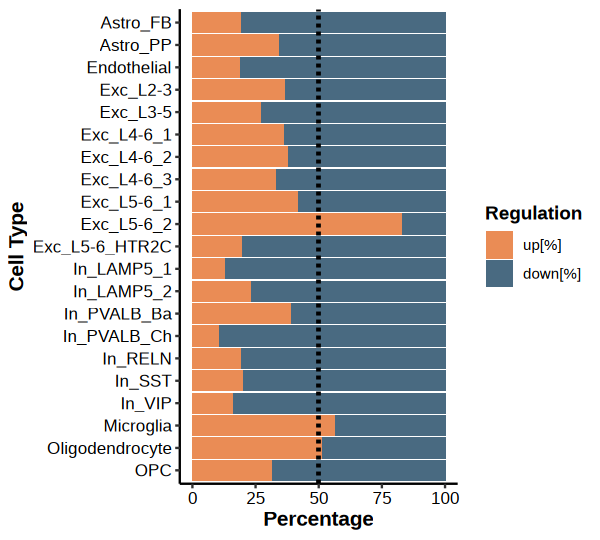

In [3]:
#make a table with DE genes total, DE up, DE down
DE_counts <- as.data.frame(matrix(ncol=3, nrow=length(celltypes)))
colnames(DE_counts) <- c('total', 'upregulated', 'downregulated')
rownames(DE_counts) <- celltypes
for (celltype in celltypes){
  DE_counts[celltype, 1] <- length(DE_genes_Age_FDR5[[celltype]]$logFC)
  DE_counts[celltype, 2] <- length(up[[celltype]]$logFC)
  DE_counts[celltype, 3] <- length(down[[celltype]]$logFC)
}
DE_counts$celltype <- rownames(DE_counts)
DE_counts$`up[%]` <- 100*(DE_counts$upregulated/DE_counts$total)
DE_counts$`down[%]` <- 100*(DE_counts$downregulated/DE_counts$total)

long_DE_counts <- DE_counts %>% 
  pivot_longer(
    cols = 5:6, 
    names_to = "Regulation",
    values_to = "Percentage"
  )

long_DE_counts$Percentage <- round(long_DE_counts$Percentage, digits = 1)

long_DE_counts$celltype <- factor(long_DE_counts$celltype, 
                                  levels=rev(c("Astro_FB", "Astro_PP", "Endothelial", "Exc_L2-3", "Exc_L3-5", 
                                               "Exc_L4-6_1", "Exc_L4-6_2", "Exc_L4-6_3", "Exc_L5-6_1", 
                                               "Exc_L5-6_2", "Exc_L5-6_HTR2C", "In_LAMP5_1", "In_LAMP5_2", 
                                               "In_PVALB_Ba", "In_PVALB_Ch", "In_RELN", "In_SST", "In_VIP", 
                                               "Microglia", "Oligodendrocyte", "OPC")))
# plot % of up-/downregulated genes
options(repr.plot.width=5, repr.plot.height=4.5)
ggplot(data=long_DE_counts, aes(x=celltype, y=Percentage, fill=Regulation)) + 
  geom_bar(stat='identity') + coord_flip() + 
scale_fill_manual(values = c("#EA8C55", "#496A81"), breaks =c('up[%]', 'down[%]') ) + theme_classic() + 
theme(axis.text=element_text(size=10, color = 'black'),  axis.title=element_text(size=12,face="bold"), 
      plot.title = element_text(size=16, face='bold'), legend.title=element_text(face='bold')) + 
geom_hline(yintercept = 50, linetype="dashed", color = "black", linewidth=1) + xlab('Cell Type')

#ggsave(filename='../figures/stacked_percentage_DE_counts_Age_directionality.pdf',last_plot(), width = 5, height = 5)

In [4]:
DE_counts

,total,upregulated,downregulated,celltype,up[%],down[%]
,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
Astro_FB,97,19,78,Astro_FB,19.58763,80.41237
Astro_PP,168,58,110,Astro_PP,34.52381,65.47619
Endothelial,26,5,21,Endothelial,19.23077,80.76923
Exc_L2-3,1189,437,752,Exc_L2-3,36.75357,63.24643
Exc_L3-5,161,44,117,Exc_L3-5,27.32919,72.67081
Exc_L4-6_1,584,213,371,Exc_L4-6_1,36.47260,63.52740
Exc_L4-6_2,731,279,452,Exc_L4-6_2,38.16689,61.83311
Exc_L4-6_3,244,81,163,Exc_L4-6_3,33.19672,66.80328
Exc_L5-6_1,110,46,64,Exc_L5-6_1,41.81818,58.18182


In [5]:
DE_counts$celltype <- factor(DE_counts$celltype, levels=c("Astro_FB", "Astro_PP", "Endothelial", "Exc_L2-3", 
                                                          "Exc_L3-5", "Exc_L4-6_1", "Exc_L4-6_2","Exc_L4-6_3", 
                                                          "Exc_L5-6_1", "Exc_L5-6_2", "Exc_L5-6_HTR2C", 
                                                          "In_LAMP5_1", "In_LAMP5_2", "In_PVALB_Ba", 
                                                          "In_PVALB_Ch", "In_RELN", "In_SST", "In_VIP",
                                                          "Microglia", "Oligodendrocyte", "OPC"))

ct_colours <- c("#BCAC9B","#DDC9B4","#6e4c3c", "#2B3A67","#588157","#A3B18A", "#2A3D45", "#496A81", "#66999B", 
  "#748b97", "#727D71","#C17C74", "#dab2ad", "#E26D5C","#EA8C55","#781F19","#723D46","#472D30","#7A6C5D",
  "#FFE1A8","#FFC482")

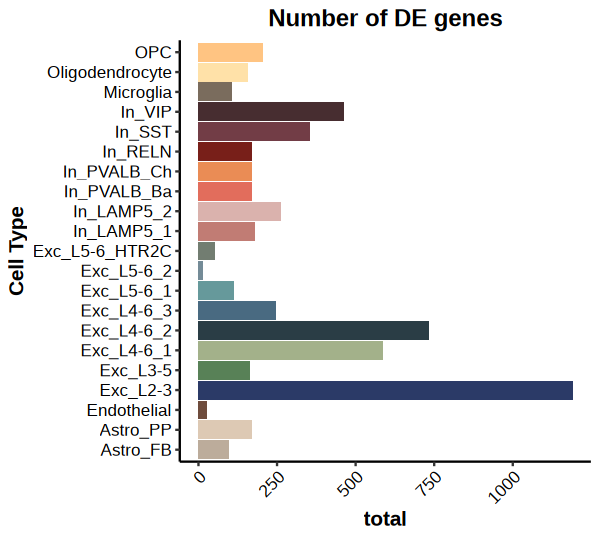

In [6]:
ggplot(data=DE_counts , aes(x=celltype, y=total, fill=celltype )) +
  geom_bar(stat="identity") + theme_classic() + theme(legend.position="none") + 
theme(axis.text.x = element_text(angle = 45, hjust=1)) + ggtitle('Number of DE genes') + theme(
    plot.title = element_text(color="black", size=14, face="bold", hjust = 0.5),
    axis.title.x = element_text(color="black", size=12, face="bold"),
    axis.title.y = element_text(color="black", size=12, face="bold"),
    axis.text = element_text(size = 10, color='black')) + coord_flip() + 
scale_fill_manual(values =ct_colours) + xlab(label='Cell Type') 

#ggsave('../figures/n_DE_genes_barplot_dreamlet.pdf', plot = last_plot(), height=5, width = 4)

## Extended Data Fig 4b - Violin plot (effect size distribution)

In [7]:
# format for violin plot

# named vector with cell-type specific colors
colours <- c("#BCAC9B","#DDC9B4", '#6e4c3c', "#2B3A67","#588157","#A3B18A", "#2A3D45", "#496A81", "#66999B", 
             "#748b97", "#727D71","#C17C74","#dab2ad", "#E26D5C","#EA8C55","#781F19","#723D46","#472D30",
             "#7A6C5D","#FFE1A8","#FFC482")
names(colours) <- names(up)

for (celltype in names(up)){
  up[[celltype]]$celltype <- celltype
  up[[celltype]]$colour <- colours[[celltype]]
  down[[celltype]]$celltype <- celltype
  down[[celltype]]$colour <- colours[[celltype]]
}

In [8]:
up_df <- rbindlist(up, use.names=TRUE, fill=FALSE, idcol=NULL)
down_df <- rbindlist(down, use.names=TRUE, fill=FALSE, idcol=NULL)

up_df$celltype <- factor(up_df$celltype, levels=rev(c("Astro_FB", "Astro_PP", "Endothelial", "Exc_L2-3", "Exc_L3-5", "Exc_L4-6_1", "Exc_L4-6_2", "Exc_L4-6_3", "Exc_L5-6_1","Exc_L5-6_2","Exc_L5-6_HTR2C", "In_LAMP5_1", "In_LAMP5_2", "In_PVALB_Ba", "In_PVALB_Ch", 'In_RELN', "In_SST", "In_VIP", "Microglia", "Oligodendrocyte", "OPC")))

down_df$celltype <- factor(down_df$celltype, levels=rev(c("Astro_FB", "Astro_PP", "Endothelial", "Exc_L2-3", "Exc_L3-5", "Exc_L4-6_1", "Exc_L4-6_2", "Exc_L4-6_3", "Exc_L5-6_1","Exc_L5-6_2","Exc_L5-6_HTR2C", "In_LAMP5_1", "In_LAMP5_2", "In_PVALB_Ba", "In_PVALB_Ch", 'In_RELN', "In_SST", "In_VIP", "Microglia", "Oligodendrocyte", "OPC")))

# calculate fold change per 10 years
up_df$FC_per_10_years <- (2^up_df$logFC-1)*10+1
down_df$FC_per_10_years <- (2^down_df$logFC-1)*10-1

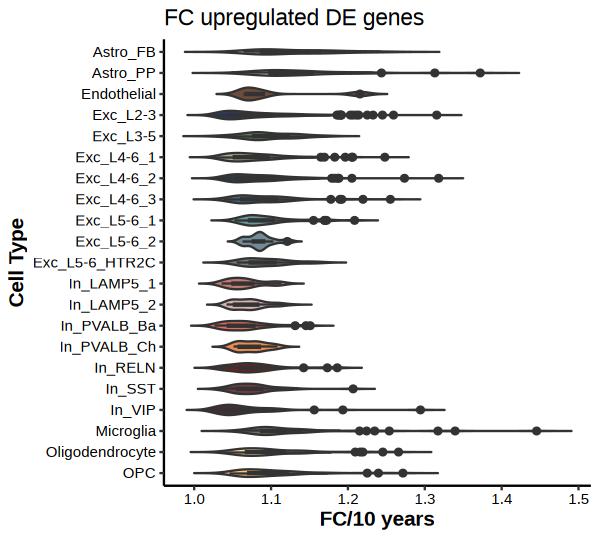

In [9]:
up_plot_FC_per_10_years <- ggplot(up_df, aes(x=celltype, y=FC_per_10_years, fill=celltype)) + 
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white")+
  labs(title="FC upregulated DE genes",x="Cell Type", y = "FC/10 years")  + theme_classic() + theme(legend.position = "none") +scale_fill_manual(values=colours) + coord_flip() + theme(axis.text = element_text(color = 'black'), axis.title = element_text(size = 12, face='bold')) 
up_plot_FC_per_10_years
#ggsave('../figures/violin_plot_effect_sizes_up.pdf', plot = up_plot_FC_per_10_years, height=5, width = 4)

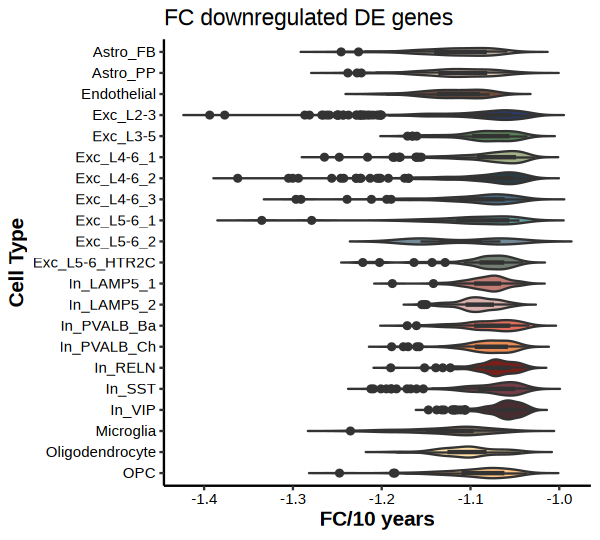

In [10]:
down_plot_FC_per_10_years <- ggplot(down_df, aes(x=celltype, y=FC_per_10_years, fill=celltype)) + 
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white")+
  labs(title="FC downregulated DE genes",x="Cell Type", y = "FC/10 years")  + theme_classic() + theme(legend.position = "none") +scale_fill_manual(values=colours) + coord_flip() + theme(axis.text = element_text(color = 'black'), axis.title = element_text(size = 12, face='bold')) 
down_plot_FC_per_10_years
#ggsave('../figures/violin_plot_effect_sizes_down.pdf', plot = down_plot_FC_per_10_years, height=5, width = 4)

## Extended Data Fig 6a,b - Upset plot 

### Cell Types

In [11]:
# prep data for Upset plot
up_diff_genes <- list()
down_diff_genes <- list()

# extract the differentially expressed genes as a vector per celltype and put it in a list
for (celltype in names(DE_genes_Age_FDR5)){
    tmp <- as.vector(up[[celltype]]["ID"]$ID)
    diff_genes_list <- list(celltype = tmp)
    up_diff_genes <- append(up_diff_genes, diff_genes_list)
}
names(up_diff_genes) <- names(DE_genes_Age_FDR5)


for (celltype in names(DE_genes_Age_FDR5)){
    tmp <- as.vector(down[[celltype]]["ID"]$ID)
    diff_genes_list <- list(celltype = tmp)
    down_diff_genes <- append(down_diff_genes, diff_genes_list)
}
names(down_diff_genes) <- names(DE_genes_Age_FDR5)

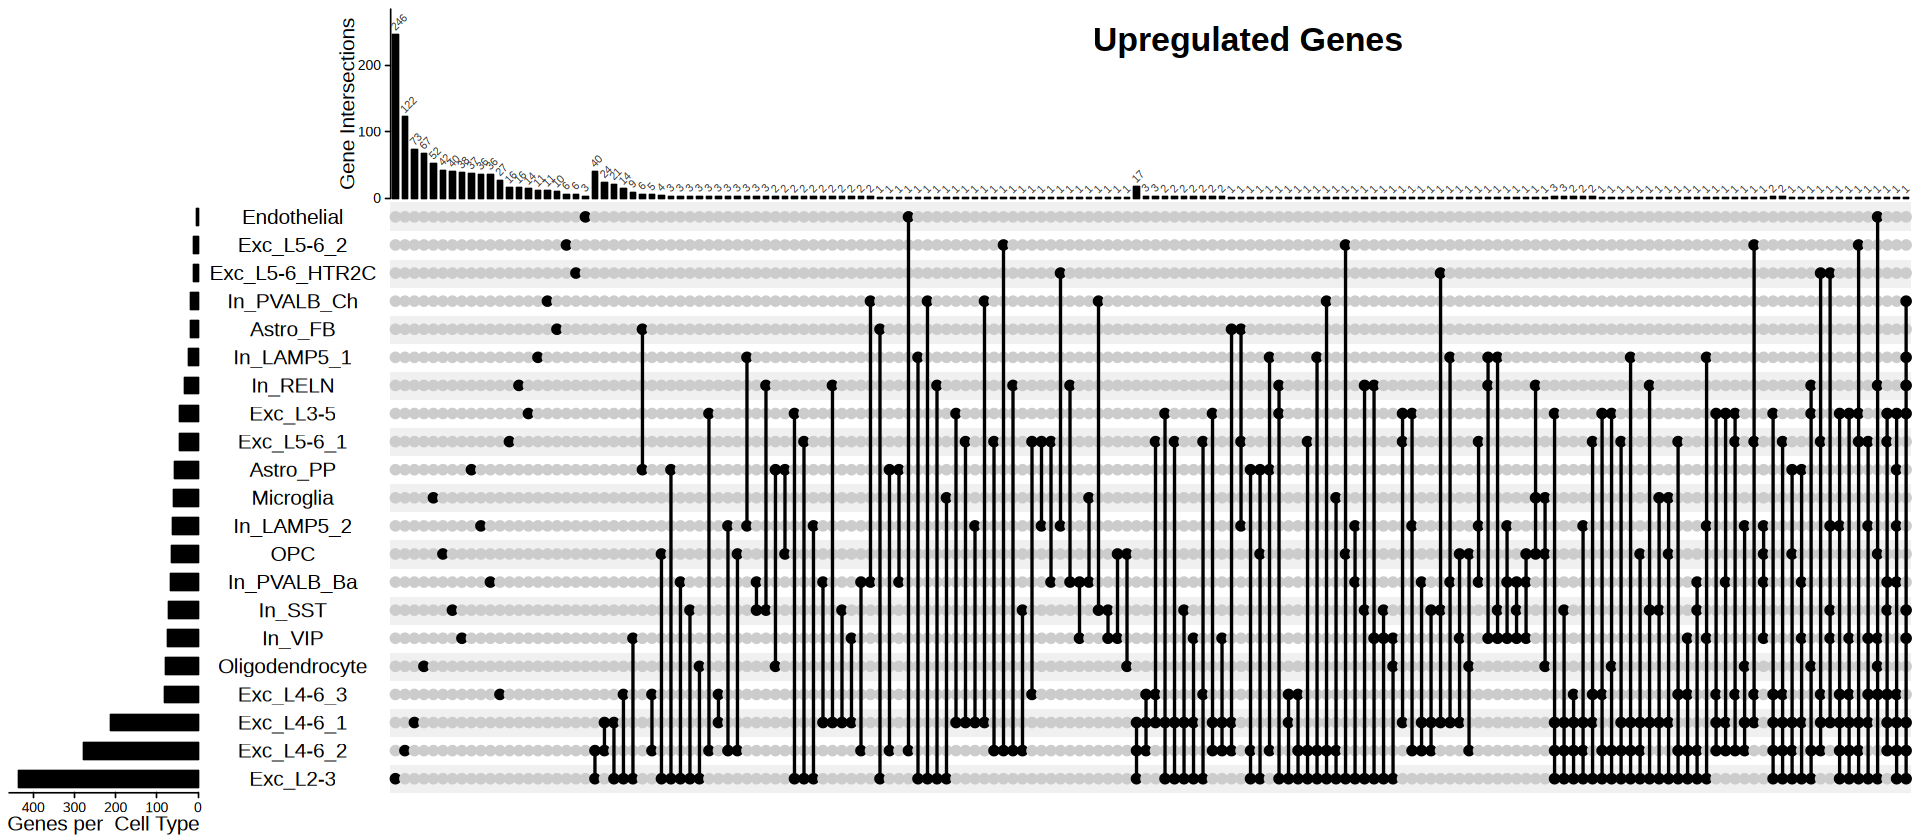

In [12]:
options(repr.plot.width=16, repr.plot.height=7)
up_plot = make_comb_mat(up_diff_genes, mode = "distinct")
ss = set_size(up_plot)
cs = comb_size(up_plot)
ht = UpSet(up_plot, 
    set_order = order(ss),
    comb_order = order(comb_degree(up_plot), -cs),
    top_annotation = HeatmapAnnotation(
        "Gene Intersections" = anno_barplot(cs, 
            ylim = c(0, max(cs)*1.1),
            border = FALSE, 
            gp = gpar(fill = "black"), 
            height = unit(4, "cm")
        ), 
        annotation_name_side = "left", 
        annotation_name_rot = 90),
    left_annotation = rowAnnotation(
        "Genes per  Cell Type" = anno_barplot(-ss, 
            baseline = 0,
            axis_param = list(
                at = c(0, -100, -200, -300, -400),
                labels = c(0, 100, 200, 300, 400),
                labels_rot = 0),
            border = FALSE, 
            gp = gpar(fill = "black"), 
            width = unit(4, "cm")
        ),
        set_name = anno_text(set_name(up_plot), 
            location = 0.5, 
            just = "center",
            width = max_text_width(set_name(up_plot)) + unit(4, "mm"))
    ), 
    right_annotation = NULL,
    show_row_names = FALSE)
up_ht = draw(ht)
od = column_order(up_ht)
decorate_annotation("Gene Intersections", {
    grid.text(cs[od], x = seq_along(cs), y = unit(cs[od], "native") + unit(2, "pt"), 
        default.units = "native", just = c("left", "bottom"), 
        gp = gpar(fontsize = 6, col = "#404040"), rot = 45)
})
grid.text(expression(bold("Upregulated Genes")),x = 0.65, y=0.95, gp=gpar(fontsize=20))

In [13]:
#save file
pdf(file="../figures/UpSetplot_DE_Age_up_Complex_heatmap.pdf", width=25, height=6)
up_ht = draw(ht)
od = column_order(up_ht)
decorate_annotation("Gene Intersections", {
    grid.text(cs[od], x = seq_along(cs), y = unit(cs[od], "native") + unit(2, "pt"), 
        default.units = "native", just = c("left", "bottom"), 
        gp = gpar(fontsize = 6, col = "#404040"), rot = 45)
})
grid.text(expression(bold("Upregulated Genes")),x = 0.65, y=0.95, gp=gpar(fontsize=15))
dev.off()

png 
  2

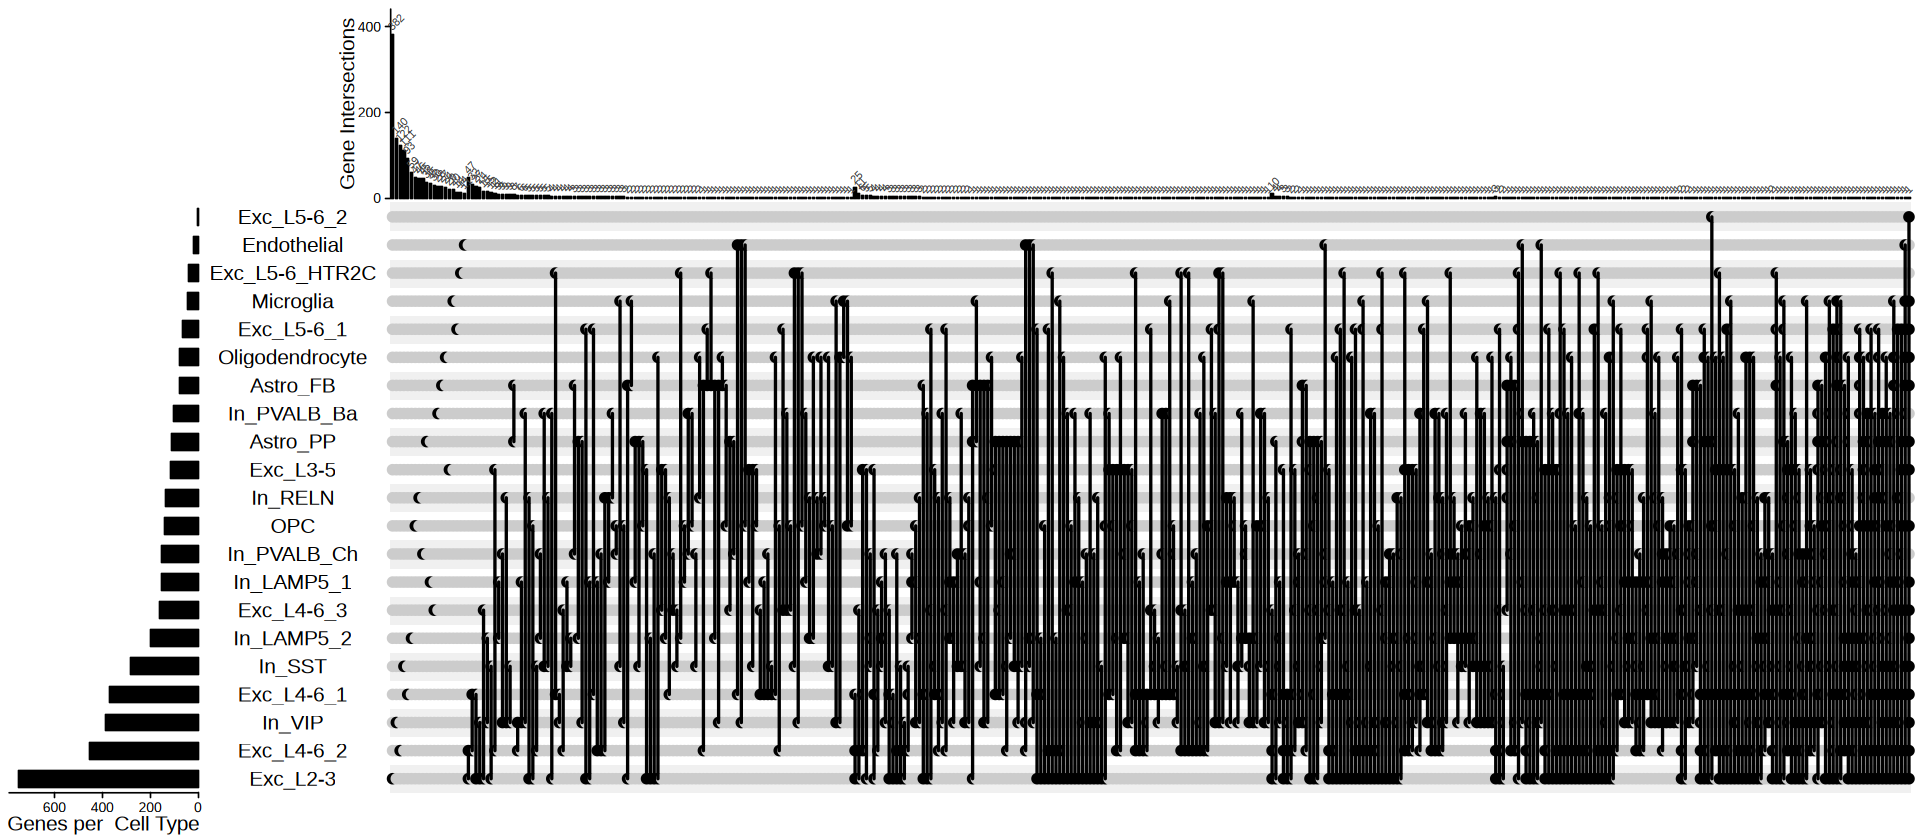

In [14]:
down_plot = make_comb_mat(down_diff_genes, mode = "distinct")
ss = set_size(down_plot)
cs = comb_size(down_plot)
ht = UpSet(down_plot, 
    set_order = order(ss),
    comb_order = order(comb_degree(down_plot), -cs),
    top_annotation = HeatmapAnnotation(
        "Gene Intersections" = anno_barplot(cs, 
            ylim = c(0, max(cs)*1.1),
            border = FALSE, 
            gp = gpar(fill = "black"), 
            height = unit(4, "cm")
        ), 
        annotation_name_side = "left", 
        annotation_name_rot = 90),
    left_annotation = rowAnnotation(
        "Genes per  Cell Type" = anno_barplot(-ss, 
            baseline = 0,
            axis_param = list(
                at = c(0, -200, -400, -600),
                labels = c(0, 200, 400, 600),
                labels_rot = 0),
            border = FALSE, 
            gp = gpar(fill = "black"), 
            width = unit(4, "cm")
        ),
        set_name = anno_text(set_name(down_plot), 
            location = 0.5, 
            just = "center",
            width = max_text_width(set_name(down_plot)) + unit(4, "mm"))
    ), 
    right_annotation = NULL,
    show_row_names = FALSE)
down_ht = draw(ht)
od = column_order(down_ht)
decorate_annotation("Gene Intersections", {
    grid.text(cs[od], x = seq_along(cs), y = unit(cs[od], "native") + unit(2, "pt"), 
        default.units = "native", just = c("left", "bottom"), 
        gp = gpar(fontsize = 6, col = "#404040"), rot = 45)
})

In [15]:
#save file
pdf(file="../figures/UpSetplot_DE_Age_down_Complex_heatmap.pdf", width=25, height=6)
down_ht = draw(ht)
od = column_order(down_ht)
decorate_annotation("Gene Intersections", {
    grid.text(cs[od], x = seq_along(cs), y = unit(cs[od], "native") + unit(2, "pt"), 
        default.units = "native", just = c("left", "bottom"), 
        gp = gpar(fontsize = 6, col = "#404040"), rot = 45)
})
grid.text(expression(bold("Downregulated Genes")),x = 0.65, y=0.95, gp=gpar(fontsize=15))
dev.off()

png 
  2

# Similarity index - Fig. 2d

In [16]:
# check how many genes are DE in total
all_DE_genes <- c()
# extract the differentially expressed genes as a vector per celltype and put it in a list
for (celltype in names(DE_genes_Age_FDR5)){
  tmp <- DE_genes_Age_FDR5[[celltype]]$ID
  all_DE_genes <- append(all_DE_genes, tmp)
}

length(unique(all_DE_genes)) #3299

[1] 3299

In [17]:
# for each celltype get the up or down DE genes that are only DE in this specific celltype

up_unique_celltype_DE_genes <- list()
for (celltype in names(up)){
  list_of_all_other_celltypes <- celltypes[!celltypes %in% celltype]
  all_DE_genes <- c()
  for (i in list_of_all_other_celltypes){
    temp <- up[[i]]$ID
    all_DE_genes <- append(all_DE_genes, temp)
  }
  up_unique_celltype_DE_genes[[celltype]] <- up[[celltype]][!up[[celltype]]$ID %in% all_DE_genes, ]
}

down_unique_celltype_DE_genes <- list()
for (celltype in names(down)){
  list_of_all_other_celltypes <- celltypes[!celltypes %in% celltype]
  all_DE_genes <- c()
  for (i in list_of_all_other_celltypes){
    temp <- down[[i]]$ID
    all_DE_genes <- append(all_DE_genes, temp)
  }
  down_unique_celltype_DE_genes[[celltype]] <- down[[celltype]][!down[[celltype]]$ID %in% all_DE_genes, ]
}

# calculate percentage of unique up & down DE genes

up_celltype_quant <- as.data.frame(matrix(ncol=4, nrow=0))
colnames(up_celltype_quant) <- c('celltype', 'n_DE_genes_up', 'n_unique_DE_genes_up', 'proportion')

for (celltype in names(up)){
  quant <- as.data.frame(matrix(ncol=4, nrow=1))
  colnames(quant) <- c('celltype', 'n_DE_genes_up', 'n_unique_DE_genes_up', 'proportion')
  quant$celltype <- celltype
  quant$n_DE_genes_up <- length(up[[celltype]]$ID)
  quant$n_unique_DE_genes_up <- length(up_unique_celltype_DE_genes[[celltype]]$ID)
  quant$proportion <- quant$n_unique_DE_genes_up/quant$n_DE_genes_up
  up_celltype_quant <- rbind(up_celltype_quant, quant)
}
#up_celltype_quant


down_celltype_quant <- as.data.frame(matrix(ncol=4, nrow=0))
colnames(down_celltype_quant) <- c('celltype', 'n_DE_genes_down', 'n_unique_DE_genes_down', 'proportion')

for (celltype in names(down)){
  quant <- as.data.frame(matrix(ncol=4, nrow=1))
  colnames(quant) <- c('celltype', 'n_DE_genes_down', 'n_unique_DE_genes_down', 'proportion')
  quant$celltype <- celltype
  quant$n_DE_genes_down <- length(down[[celltype]]$ID)
  quant$n_unique_DE_genes_down <- length(down_unique_celltype_DE_genes[[celltype]]$ID)
  quant$proportion <- quant$n_unique_DE_genes_down/quant$n_DE_genes_down
  down_celltype_quant <- rbind(down_celltype_quant, quant)
}
head(down_celltype_quant)

,celltype,n_DE_genes_down,n_unique_DE_genes_down,proportion
,<chr>,<int>,<int>,<dbl>
1,Astro_FB,78,27,0.3461538
2,Astro_PP,110,36,0.3272727
3,Endothelial,21,11,0.5238095
4,Exc_L2-3,752,382,0.5079787
5,Exc_L3-5,117,20,0.1709402
6,Exc_L4-6_1,371,93,0.2506739


In [18]:
##### UP #####

# order cell types into Exc Neurons, In Neurons and Glial Cells
Exc_In_Glia <- c("Exc_L2-3", "Exc_L3-5", "Exc_L4-6_1", "Exc_L4-6_2", "Exc_L4-6_3", 
               "Exc_L5-6_1","Exc_L5-6_2", "Exc_L5-6_HTR2C", "In_LAMP5_1", "In_LAMP5_2", "In_PVALB_Ba", "In_PVALB_Ch", 
               "In_RELN", "In_SST", "In_VIP", "Astro_FB", "Astro_PP", "Endothelial", "Microglia", "Oligodendrocyte", "OPC")


#sort so that celltype proportion are in the correct order
up_celltype_quant <- up_celltype_quant[match(Exc_In_Glia, up_celltype_quant$celltype),]

full_corr_matrix_up_GS <- as.data.frame(matrix(ncol=20, nrow=0))
for (i in names(DE_genes_Age_FDR5)){
  corr_matrix <- as.data.frame(matrix(ncol=21, nrow=1))
  colnames(corr_matrix) <- names(DE_genes_Age_FDR5)
  rownames(corr_matrix) <- i
  for (celltype in names(DE_genes_Age_FDR5)){
    overlap <- 
      length(intersect(up[[i]]$ID, up[[celltype]]$ID))
    per_c1 <- overlap/length(up[[i]]$ID)
    per_c2 <- overlap/length(up[[celltype]]$ID)
    percentage <- (per_c1 + per_c2)/2
    corr_matrix[i, celltype] <- percentage
  } 
  full_corr_matrix_up_GS <- rbind(full_corr_matrix_up_GS, corr_matrix)
}

colnames(full_corr_matrix_up_GS) <- c("Ex1", "Ex2", "Ex3", "Ex4", "Ex5", "Ex6", "Ex7", "Ex8", "In1", "In2", "In3", "In4", "In5", "In6", "In7", "Ast1", "Ast2", "Endo", "Mic", "Oli", "OPC") 
rownames(full_corr_matrix_up_GS) <- c("Ex1", "Ex2", "Ex3", "Ex4", "Ex5", "Ex6", "Ex7", "Ex8", "In1", "In2", "In3", "In4", "In5","In6","In7", "Ast1", "Ast2","Endo", "Mic", "Oli", "OPC") 


##### DOWN #####

#sort so that celltype proportion are in the correct order
down_celltype_quant <- down_celltype_quant[match(Exc_In_Glia, down_celltype_quant$celltype),]


# now consider sum DE_genes of the two celltypes in comparison as the Grundsatz
full_corr_matrix_down_GS <- as.data.frame(matrix(ncol=20, nrow=0))
for (i in names(DE_genes_Age_FDR5)){
  corr_matrix <- as.data.frame(matrix(ncol=21, nrow=1))
  colnames(corr_matrix) <- names(DE_genes_Age_FDR5)
  rownames(corr_matrix) <- i
  for (celltype in names(DE_genes_Age_FDR5)){
    overlap <- 
      length(intersect(down[[i]]$ID, down[[celltype]]$ID))
    per_c1 <- overlap/length(down[[i]]$ID)
    per_c2 <- overlap/length(down[[celltype]]$ID)
    percentage <- (per_c1 + per_c2)/2
    corr_matrix[i, celltype] <- percentage
  } 
  full_corr_matrix_down_GS <- rbind(full_corr_matrix_down_GS, corr_matrix)
}

colnames(full_corr_matrix_down_GS) <- c("Ex1", "Ex2", "Ex3", "Ex4", "Ex5", "Ex6", "Ex7", "Ex8", "In1", "In2", "In3", "In4", "In5", "In6","In7", "Ast1", "Ast2", "Endo", "Mic", "Oli", "OPC") 
rownames(full_corr_matrix_down_GS) <- c("Ex1", "Ex2", "Ex3", "Ex4", "Ex5", "Ex6", "Ex7", "Ex8", "In1", "In2", "In3", "In4", "In5", "In6", "In7", "Ast1", "Ast2", "Endo", "Mic", "Oli", "OPC") 

In [19]:
full_corr_matrix_down_GS[1:5,1:5]

,Ex1,Ex2,Ex3,Ex4,Ex5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ex1,1.00000000,0.24102564,0.03021978,0.12027755,0.05341880
Ex2,0.24102564,1.00000000,0.05670996,0.16673114,0.12346542
Ex3,0.03021978,0.05670996,1.00000000,0.02447442,0.02808303
Ex4,0.12027755,0.16673114,0.02447442,1.00000000,0.23704310
Ex5,0.05341880,0.12346542,0.02808303,0.23704310,1.00000000


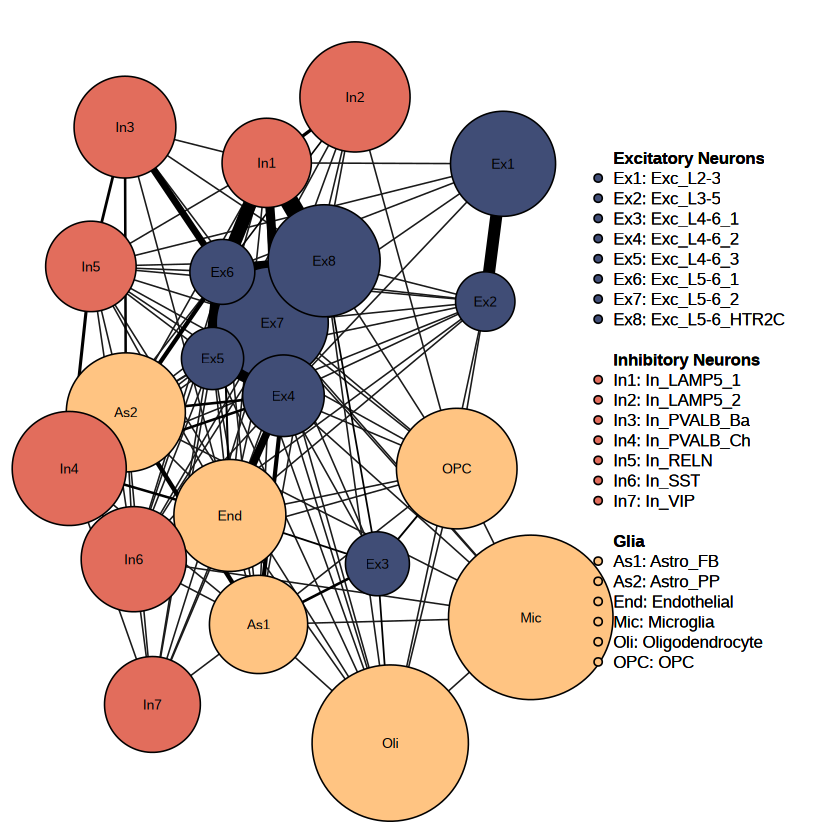

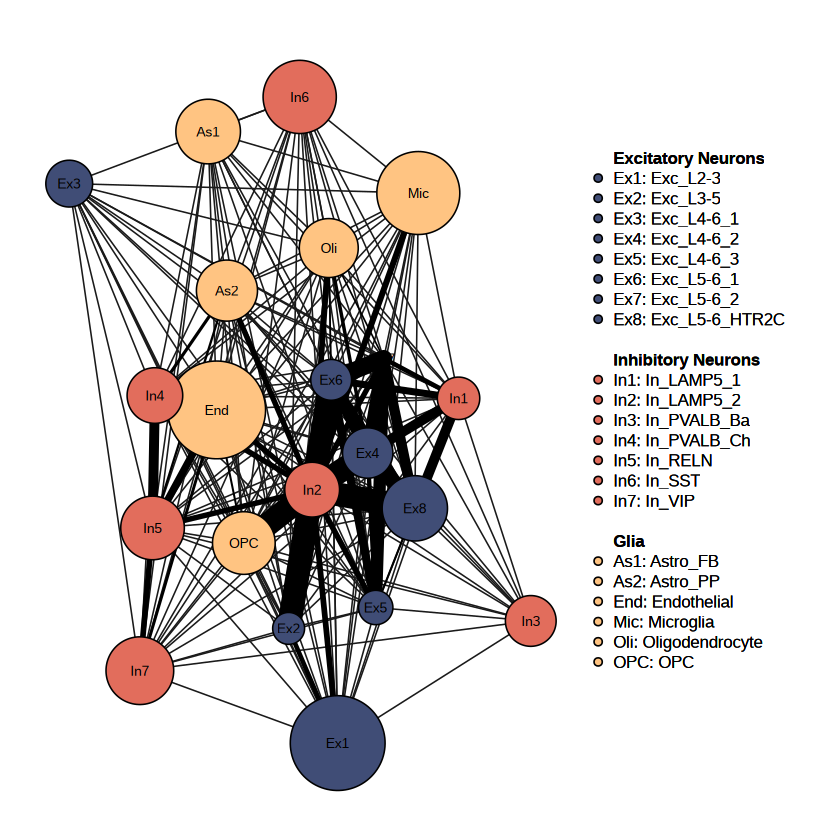

In [20]:
library(qgraph)
options(repr.plot.width=7, repr.plot.height=7)
up_qgraph <- qgraph(full_corr_matrix_up_GS , layout='spring', 
               groups = list(`Excitatory Neurons` = 1:8, `Inhibitory Neurons` = 9:15, Glia = 16:21), 
                    color = c("#404d76","#E26D5C", '#FFC482'), theme='gray', esize=15, shape='circle',  
                    label.scale=F, label.cex=0.65, nodeNames=Exc_In_Glia, 
                    legend.mode='style1', legend.cex=0.4, vsize=up_celltype_quant$proportion*21, 
                    vsize2=up_celltype_quant$proportion*21, fade=F)

#qgraph(up_qgraph, filetype='pdf', width = 6,height = 6, filename="../figures/qgraph_up_DE_genes_FDR5_all_cts")

down_qgraph <- qgraph(full_corr_matrix_down_GS , layout='spring', 
               groups = list(`Excitatory Neurons` = 1:8, `Inhibitory Neurons` = 9:15, Glia = 16:21), 
                       color = c("#404d76","#E26D5C", '#FFC482'),  theme='gray', esize=15, shape='circle',  
                       label.scale=F, label.cex=0.65, nodeNames=Exc_In_Glia, legend.mode='style1', legend.cex=0.4, 
                       vsize=down_celltype_quant$proportion*21, vsize2=down_celltype_quant$proportion*21, fade=F)

#qgraph(down_qgraph, filetype='pdf', width = 6,height = 6, filename="../figures/qgraph_down_DE_genes_FDR5_all_cts")

# read in mashR results

In [21]:
mashR_estimated_pi <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/mash_results_DE_Age_20231121.xlsx', sheet = 'estimated_pi'))
mashR_posterior_sd <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/mash_results_DE_Age_20231121.xlsx', sheet = 'p_sd'))
mashR_posterior_mean_logFC <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/mash_results_DE_Age_20231121.xlsx', sheet = 'pm_logFC'))
mashR_lsfr <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/mash_results_DE_Age_20231121.xlsx', sheet = 'lsfr'))

In [22]:
# get genes expressed in all celltypes
# i.e. genes that do not have NAs
shared_genes_mash <- as.data.frame(na.omit(mashR_lsfr))
dim(shared_genes_mash)
head(shared_genes_mash)[1:6,1:6]

[1] 998  22

,genes,Exc_L2-3,Exc_L3-5,Exc_L4-6_1,Exc_L4-6_2,Exc_L4-6_3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12,AAK1,5.414935e-01,5.415097e-01,5.425121e-01,5.253044e-01,5.433870e-01
79,ABHD2,3.563647e-01,3.989416e-01,4.458030e-01,2.095878e-03,3.732577e-01
86,ABI2,5.880829e-10,9.555258e-05,4.378686e-11,8.528313e-10,8.359229e-07
92,ABLIM1,7.151481e-01,6.709696e-01,5.971228e-01,5.958208e-01,7.126500e-01
96,ABR,3.055750e-01,3.100363e-01,3.070172e-01,3.115847e-01,3.100300e-01
2153,ACACA,6.435423e-01,6.466861e-01,6.471434e-01,6.430131e-01,6.491017e-01


In [23]:
# extract all the genes with lsfr < 0.05
genes <- (shared_genes_mash %>% filter(`Exc_L2-3` < 0.05 & `Exc_L3-5` < 0.05 & `Exc_L4-6_1` < 0.05 & `Exc_L4-6_2` < 0.05 & 
                                 `Exc_L4-6_3` < 0.05 & `Exc_L5-6_1` < 0.05 & `Exc_L5-6_2` < 0.05 & `Exc_L5-6_HTR2C` < 0.05 &
                                In_LAMP5_1 < 0.05 & In_LAMP5_2 < 0.05 & In_PVALB_Ba < 0.05 & In_PVALB_Ch < 0.05 & In_RELN < 0.05 & 
                                 In_SST < 0.05 & In_VIP < 0.05 & Astro_FB < 0.05 & Astro_PP < 0.05 & Microglia < 0.05 &
                                 Oligodendrocyte < 0.05 & OPC < 0.05 & Endothelial < 0.05))$genes

print(paste0('number of shared genes with lsfr < 0.05: ', length(genes)))

[1] "number of shared genes with lsfr < 0.05: 256"


In [24]:
#extract the logFC of shared genes
posterior_mean_logFC_shared_genes <- mashR_posterior_mean_logFC[mashR_posterior_mean_logFC$genes %in% genes,]

#make genes rownames and delete the column genes
rownames(posterior_mean_logFC_shared_genes) <- posterior_mean_logFC_shared_genes$genes
posterior_mean_logFC_shared_genes$genes <- NULL

head(posterior_mean_logFC_shared_genes)[1:6,1:6]
dim(posterior_mean_logFC_shared_genes)

posterior_mean_logFC_shared_genes$genes <- rownames(posterior_mean_logFC_shared_genes)
posterior_mean_logFC_long_format <- posterior_mean_logFC_shared_genes %>% 
  pivot_longer(
    cols = 1:21, 
    names_to = "cell type",
    values_to = "posterior_mean_logFC"
  )
head(posterior_mean_logFC_long_format)

,Exc_L2-3,Exc_L3-5,Exc_L4-6_1,Exc_L4-6_2,Exc_L4-6_3,Exc_L5-6_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABI2,-0.004256917,-0.004106249,-0.004250272,-0.004223773,-0.004223550,-0.004194821
ACTB,-0.005671111,-0.005829050,-0.005835560,-0.005623769,-0.005765902,-0.005775252
ACTR2,-0.004753701,-0.004698627,-0.004742514,-0.004710894,-0.004730269,-0.004731675
ACYP2,0.002078965,0.002102056,0.002078689,0.002088005,0.002092503,0.002107787
AHI1,0.001810472,0.001838452,0.001810045,0.001844063,0.001799483,0.001849386
AKAP11,-0.003774930,-0.003770285,-0.003794032,-0.003797057,-0.003786619,-0.003748403


[1] 256  21

genes,cell type,posterior_mean_logFC
<chr>,<chr>,<dbl>
ABI2,Exc_L2-3,-0.004256917
ABI2,Exc_L3-5,-0.004106249
ABI2,Exc_L4-6_1,-0.004250272
ABI2,Exc_L4-6_2,-0.004223773
ABI2,Exc_L4-6_3,-0.004223550
ABI2,Exc_L5-6_1,-0.004194821


In [25]:
#extract the sd of shared genes
posterior_sd_shared_genes <- mashR_posterior_sd[mashR_posterior_sd$genes %in% genes,]

#make genes rownames and delete column genes
rownames(posterior_sd_shared_genes) <- posterior_sd_shared_genes$genes
posterior_sd_shared_genes$genes <- NULL

head(posterior_sd_shared_genes)[1:6,1:6]
dim(posterior_sd_shared_genes)

posterior_sd_shared_genes$genes <- rownames(posterior_sd_shared_genes)
posterior_sd_long_format <- posterior_sd_shared_genes %>% 
  pivot_longer(
    cols = 1:21, 
    names_to = "cell type",
    values_to = "posterior_sd"
  )
head(posterior_sd_long_format)

,Exc_L2-3,Exc_L3-5,Exc_L4-6_1,Exc_L4-6_2,Exc_L4-6_3,Exc_L5-6_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABI2,0.0005252355,0.0005322988,0.0005025758,0.0004653353,0.0005071729,0.0005026203
ACTB,0.0010877295,0.0010499703,0.0010699165,0.0010430763,0.0010664623,0.0010566805
ACTR2,0.0005938629,0.0006009960,0.0005809523,0.0005761718,0.0005841330,0.0005831822
ACYP2,0.0005593026,0.0005701764,0.0005613972,0.0005594900,0.0005625190,0.0005764966
AHI1,0.0006168221,0.0006133160,0.0006136613,0.0006175308,0.0006212086,0.0006318053
AKAP11,0.0005566551,0.0005574387,0.0005581339,0.0005416701,0.0005532885,0.0005935728


[1] 256  21

genes,cell type,posterior_sd
<chr>,<chr>,<dbl>
ABI2,Exc_L2-3,0.0005252355
ABI2,Exc_L3-5,0.0005322988
ABI2,Exc_L4-6_1,0.0005025758
ABI2,Exc_L4-6_2,0.0004653353
ABI2,Exc_L4-6_3,0.0005071729
ABI2,Exc_L5-6_1,0.0005026203


In [26]:
mashR_shared_genes_results <- as.data.frame(merge(posterior_mean_logFC_long_format, posterior_sd_long_format, by=c("genes","cell type")))
head(mashR_shared_genes_results)
length(unique(mashR_shared_genes_results$genes))

library(writexl)
write_xlsx(mashR_shared_genes_results, '../results/dreamlet_tables/final_celltypes_N87/mashR_shared_genes_results.xlsx', col_names = TRUE)

,genes,cell type,posterior_mean_logFC,posterior_sd
,<chr>,<chr>,<dbl>,<dbl>
1,ABI2,Astro_FB,-0.004283070,0.0006284334
2,ABI2,Astro_PP,-0.004212687,0.0005316526
3,ABI2,Endothelial,-0.004176795,0.0005329929
4,ABI2,Exc_L2-3,-0.004256917,0.0005252355
5,ABI2,Exc_L3-5,-0.004106249,0.0005322988
6,ABI2,Exc_L4-6_1,-0.004250272,0.0005025758


[1] 256

In [27]:
# separate up- vs downregulated shared genes
#select all the rows that only have positive values
posterior_mean_logFC_shared_genes$genes <- NULL
posterior_sd_shared_genes$genes <- NULL

mash_shared_UP <- rownames(posterior_mean_logFC_shared_genes %>% filter_at(colnames(posterior_mean_logFC_shared_genes), all_vars(. >= 0)))
length(mash_shared_UP)

#select all the rows that only have negative values
mash_shared_DOWN <- rownames(posterior_mean_logFC_shared_genes %>% filter_at(colnames(posterior_mean_logFC_shared_genes), all_vars(. < 0)))
length(mash_shared_DOWN)

[1] 108

[1] 148

In [28]:
df_DOWN <- posterior_mean_logFC_shared_genes[mash_shared_DOWN,]
df_DOWN <- df_DOWN[order(df_DOWN$`Exc_L2-3`),]
df_DOWN[1:4,]

df_UP <- posterior_mean_logFC_shared_genes[mash_shared_UP,]
df_UP <- df_UP[order(-df_UP$`Exc_L2-3`),]
df_UP[1:4,]

,Exc_L2-3,Exc_L3-5,Exc_L4-6_1,Exc_L4-6_2,Exc_L4-6_3,Exc_L5-6_1,Exc_L5-6_2,Exc_L5-6_HTR2C,In_LAMP5_1,In_LAMP5_2,⋯,In_PVALB_Ch,In_RELN,In_SST,In_VIP,Astro_FB,Astro_PP,Endothelial,Microglia,Oligodendrocyte,OPC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARPP19,-0.015224195,-0.012528310,-0.014571352,-0.012919235,-0.012625524,-0.013422753,-0.014868752,-0.010561546,-0.012059299,-0.013154516,⋯,-0.010452296,-0.008722261,-0.010599168,-0.009331907,-0.016051835,-0.014012467,-0.010974397,-0.013980736,-0.012823828,-0.016027443
NRGN,-0.012676649,-0.012683239,-0.012672631,-0.012555600,-0.012631404,-0.012583345,-0.012684169,-0.012592300,-0.012596985,-0.012681606,⋯,-0.012594027,-0.012622005,-0.012663044,-0.012643956,-0.012671268,-0.012676358,-0.012700005,-0.012709887,-0.012689081,-0.012686237
CAMK2N1,-0.010002063,-0.009587423,-0.009093693,-0.009258424,-0.009816444,-0.008889757,-0.009228496,-0.009610944,-0.009062656,-0.009869855,⋯,-0.008856513,-0.008912907,-0.010099544,-0.010011075,-0.009596568,-0.009509835,-0.009688452,-0.009710855,-0.008662002,-0.010120977
VAMP2,-0.008772684,-0.008689176,-0.008760423,-0.008752057,-0.008722583,-0.008646967,-0.008676655,-0.008811847,-0.008708095,-0.008988057,⋯,-0.008814846,-0.008530869,-0.008827661,-0.008751830,-0.008618406,-0.008777361,-0.008767375,-0.008777729,-0.008391736,-0.008642493


,Exc_L2-3,Exc_L3-5,Exc_L4-6_1,Exc_L4-6_2,Exc_L4-6_3,Exc_L5-6_1,Exc_L5-6_2,Exc_L5-6_HTR2C,In_LAMP5_1,In_LAMP5_2,⋯,In_PVALB_Ch,In_RELN,In_SST,In_VIP,Astro_FB,Astro_PP,Endothelial,Microglia,Oligodendrocyte,OPC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MIR29B2CHG,0.004410447,0.004472558,0.004439160,0.004404503,0.004400744,0.004475812,0.004355117,0.004498531,0.004553343,0.004455527,⋯,0.004461014,0.004419333,0.004391919,0.004471902,0.004514418,0.004489911,0.004342451,0.004339997,0.004665264,0.004533878
MALAT1,0.004316123,0.004359120,0.004343322,0.004331098,0.004356984,0.004361593,0.004376048,0.004368501,0.004319957,0.004348771,⋯,0.004337560,0.004315823,0.004284967,0.004353241,0.004341173,0.004380726,0.004350028,0.004330166,0.004341407,0.004356348
SRRM2,0.004184666,0.003557760,0.003392201,0.003645044,0.004015769,0.004330929,0.003694014,0.003931419,0.003887597,0.003483297,⋯,0.003811271,0.003611461,0.003551595,0.004066434,0.003803715,0.003779225,0.003613695,0.004036980,0.003802150,0.004053951
WWOX,0.004142969,0.004182367,0.004100098,0.004192080,0.004074371,0.004122832,0.004077831,0.004141628,0.004066032,0.004204733,⋯,0.004059359,0.004092878,0.004161218,0.004093820,0.004092902,0.004094988,0.004094526,0.004059126,0.004125176,0.004086024


## Fig. 3g - create forest plots

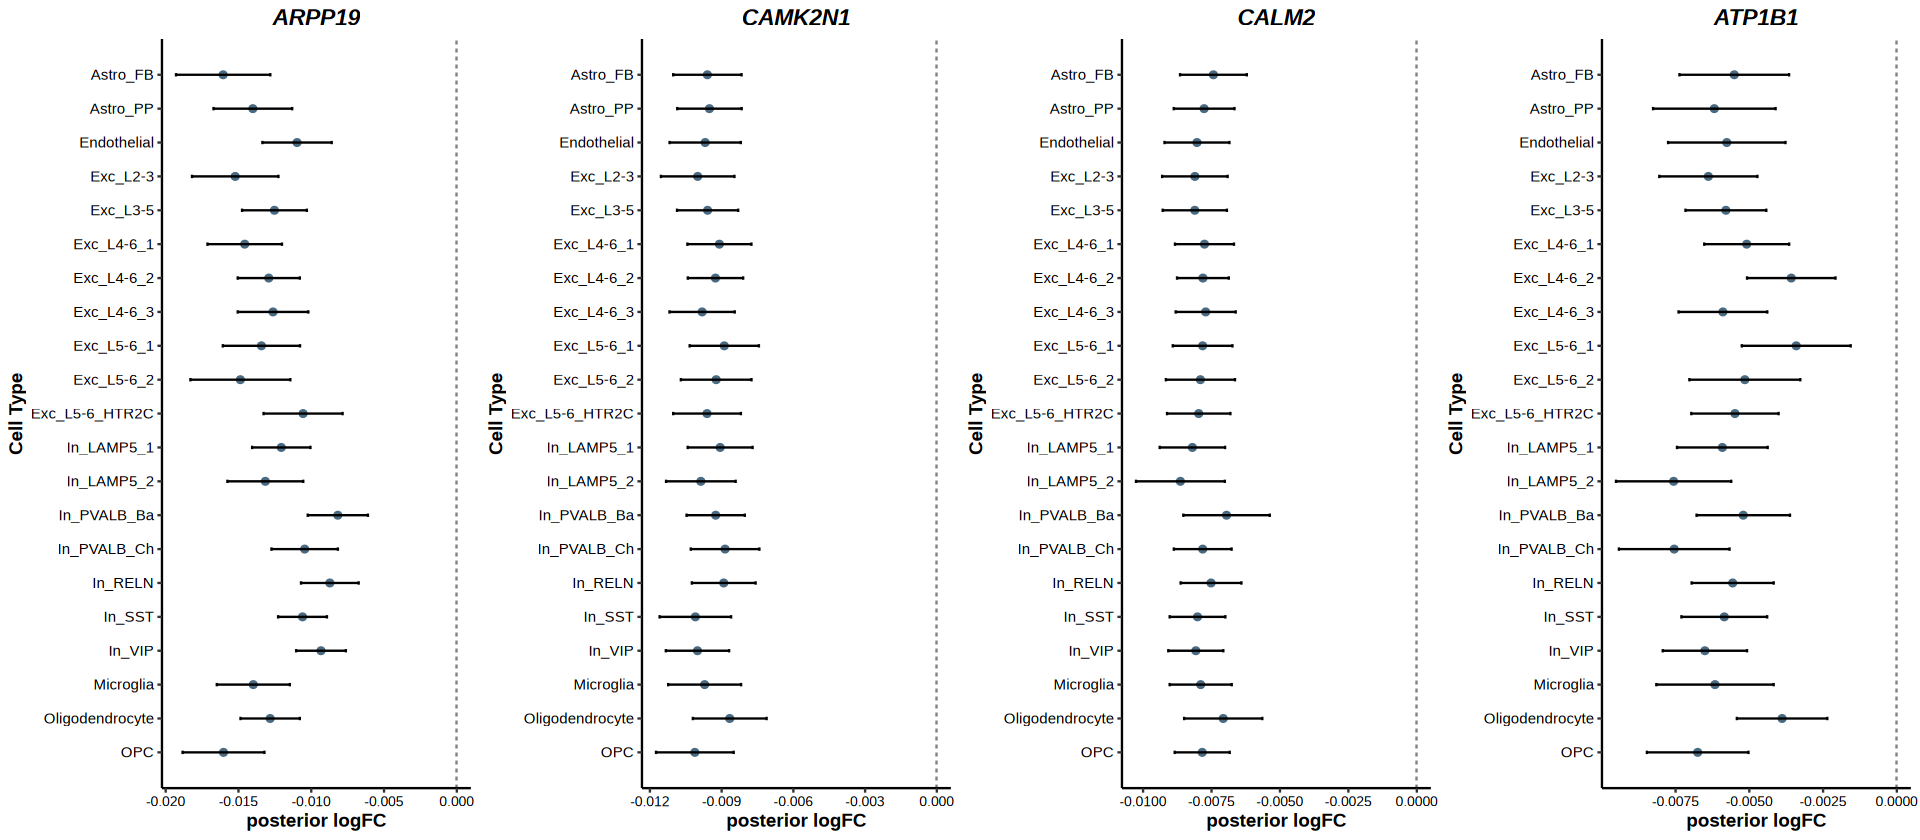

In [29]:
common_down <- c('ARPP19','CAMK2N1','CALM2','ATP1B1')
# 'ARPP19', 'NRGN','CAMK2N1','VAMP2', 'CALM2','ATP1B1','GRIN2B'

common_down_list <- list()
for (gene in common_down){
    tmp <- as.data.frame(t(posterior_mean_logFC_shared_genes)[,gene])
    colnames(tmp) <- c('p_logFC')
    tmp$gene <- gene
    tmp$celltype <- rownames(tmp)
    tmp$celltype <- factor(tmp$celltype, levels=rev(celltypes))
    tmp$p_sd <- t(posterior_sd_shared_genes)[,gene]
    tmp <- tmp[order(tmp$celltype),]
    tmp$index <- c(1:21)
    common_down_list[[gene]] <- tmp}

fig_list_down <- list()
for (gene in common_down){
    fig_list_down[[gene]] <- ggplot(data=common_down_list[[gene]], 
                                    aes(y=index, x=p_logFC, xmin=p_logFC-p_sd, xmax=p_logFC+p_sd)) +
    geom_point(colour="#496A81") +geom_errorbarh(height=.1) + scale_y_continuous(breaks=1:nrow(common_down_list[[gene]]), labels=common_down_list[[gene]]$celltype) +
    labs(title=gene, x='posterior logFC', y = 'Cell Type') + geom_vline(xintercept=0, color='black', linetype='dashed', alpha=.5) +
    theme_classic() + theme(axis.title = element_text(face='bold'), axis.text.x= element_text(color="black", size=8), 
                            axis.text.y= element_text(color="black"),
                            plot.title = element_text(face = "bold.italic", hjust=0.5))
}

options(repr.plot.width=16, repr.plot.height=7)
plot_grid(plotlist=fig_list_down[1:4] ,nrow=1)

In [30]:
#ggsave('../figures/forest_plot_mash_ARPP19.pdf', fig_list_down[['ARPP19']], width=3, height=4)
#ggsave('../figures/forest_plot_mash_CAMK2N1.pdf', fig_list_down[['CAMK2N1']], width=3, height=4)
#ggsave('../figures/forest_plot_mash_NRGN.pdf', fig_list_down[['NRGN']], width=3, height=4)

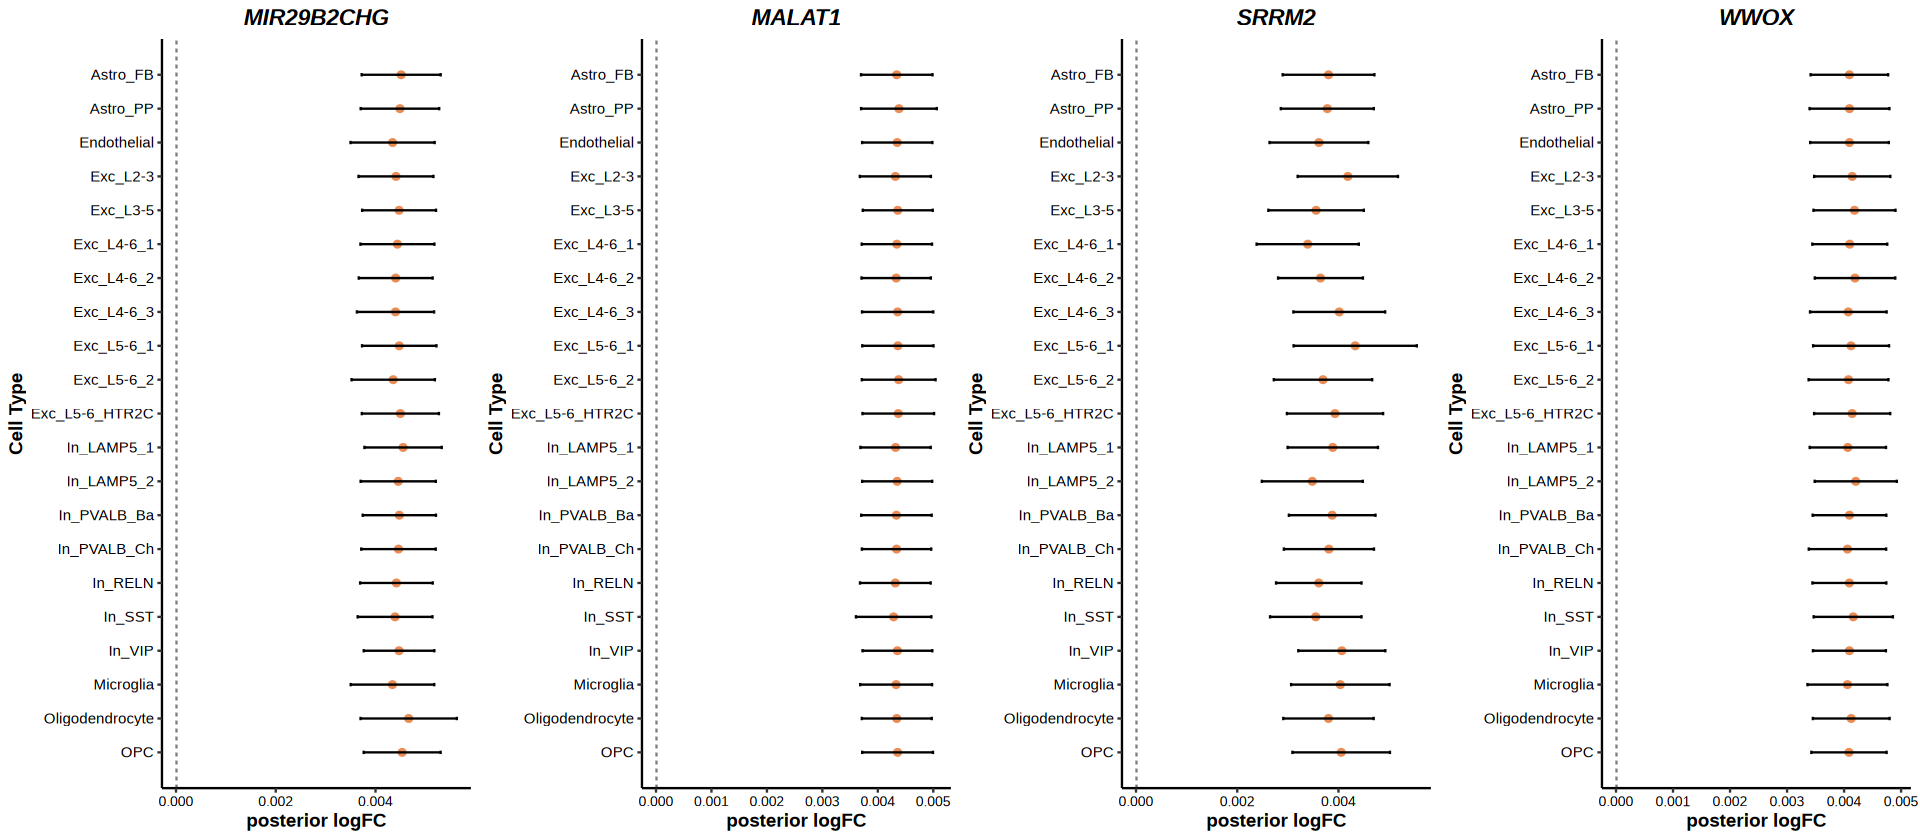

In [31]:
common_up <- c('MIR29B2CHG', 'MALAT1', 'SRRM2', 'WWOX')
# 'MIR29B2CHG', 'MALAT1', 'SNRNP70', 'SRRM2', 'WWOX'

common_up_list <- list()
for (gene in common_up){
    tmp <- as.data.frame(t(posterior_mean_logFC_shared_genes)[,gene])
    colnames(tmp) <- c('p_logFC')
    tmp$gene <- gene
    tmp$celltype <- rownames(tmp)
    tmp$celltype <- factor(tmp$celltype, levels=rev(celltypes))
    tmp$p_sd <- t(posterior_sd_shared_genes)[,gene]
    tmp <- tmp[order(tmp$celltype),]
    tmp$index <- c(1:21)
    common_up_list[[gene]] <- tmp}


fig_list_up <- list()
for (gene in common_up){
    fig_list_up[[gene]] <- ggplot(data=common_up_list[[gene]], 
                                    aes(y=index, x=p_logFC, xmin=p_logFC-p_sd, xmax=p_logFC+p_sd)) +
    geom_point(colour="#EA8C55") +geom_errorbarh(height=.1) + scale_y_continuous(breaks=1:nrow(common_up_list[[gene]]), labels=common_up_list[[gene]]$celltype) +
    labs(title=gene, x='posterior logFC', y = 'Cell Type') + geom_vline(xintercept=0, color='black', linetype='dashed', alpha=.5) +
    theme_classic() + theme(axis.title = element_text(face='bold'), axis.text.x= element_text(color="black", size=8), 
                            axis.text.y= element_text(color="black"),
                            plot.title = element_text(face = "bold.italic", hjust=0.5))
}


options(repr.plot.width=16, repr.plot.height=7)
plot_grid(plotlist=fig_list_up[1:4] ,nrow=1)

In [32]:
#ggsave('../figures/forest_plot_mash_SRRM2.pdf', fig_list_up[['SRRM2']], width=3, height=4)

# Overrepresentation Analysis (ORA)

In [33]:
# see tutorial: https://yulab-smu.top/biomedical-knowledge-mining-book/enrichment-overview.html

# setting the organism: human
suppressPackageStartupMessages({library(org.Hs.eg.db)})
#set the organism
organism <- org.Hs.eg.db

In [34]:
# define the background genes for enrichment analysis

# all genes expressed in at least one cell type
mash_background <- mashR_posterior_mean_logFC$genes
length(mash_background)

[1] 18891

## shared mashR results

In [35]:
######## DE genes AGE up only
ORA_mash_UP <- enrichGO(gene = mash_shared_UP,
                  universe = mash_background,
                  OrgDb = organism,
                  keyType = 'SYMBOL',
                  ont = "BP",
                  pAdjustMethod = "none",
                  pvalueCutoff  = 1, #set this to 1 otherwise plotting won't work because of applied filter
                  qvalueCutoff  = 1, #set this to 1 otherwise plotting won't work because of applied filter
                  readable = F)

###### filter processes by "minimum 5% of DE genes need to represent this term"
### then adjust p-value
 
filtered <- dplyr::filter(ORA_mash_UP@result, Count >= 0.05 * length(mash_shared_UP))
filtered$p.adjust <- p.adjust(filtered$pvalue, method = 'fdr', n = length(filtered$pvalue))
ORA_mash_UP_filtered_p_adjust <- ORA_mash_UP
ORA_mash_UP_filtered_p_adjust@result <- filtered

# filter for p-adjust < 0.05
sig_ORA_mash_UP <- dplyr::filter(ORA_mash_UP_filtered_p_adjust@result, p.adjust < 0.05 )
dim(sig_ORA_mash_UP)

[1] 13  9

In [36]:
head(sig_ORA_mash_UP)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0000377,GO:0000377,"RNA splicing, via transesterification reactions with bulged adenosine as nucleophile",8/94,282/12776,0.001100537,0.01204418,0.1964955,CDK13/DDX17/LUC7L3/RNPC3/RSRC1/SNRNP70/SRRM2/SRSF5,8
GO:0000398,GO:0000398,"mRNA splicing, via spliceosome",8/94,282/12776,0.001100537,0.01204418,0.1964955,CDK13/DDX17/LUC7L3/RNPC3/RSRC1/SNRNP70/SRRM2/SRSF5,8
GO:0000375,GO:0000375,"RNA splicing, via transesterification reactions",8/94,286/12776,0.001204418,0.01204418,0.1964955,CDK13/DDX17/LUC7L3/RNPC3/RSRC1/SNRNP70/SRRM2/SRSF5,8
GO:0006397,GO:0006397,mRNA processing,10/94,450/12776,0.001708043,0.01244472,0.1964955,CDK13/DDX17/LUC7L3/PABPN1/RNPC3/RSRC1/SNRNP70/SRRM2/SRSF11/SRSF5,10
GO:0018105,GO:0018105,peptidyl-serine phosphorylation,7/94,243/12776,0.002075852,0.01244472,0.1964955,AKAP9/FNIP1/MARK3/NSD1/RICTOR/RPTOR/WNK1,7
GO:0018209,GO:0018209,peptidyl-serine modification,7/94,255/12776,0.002720752,0.01244472,0.1964955,AKAP9/FNIP1/MARK3/NSD1/RICTOR/RPTOR/WNK1,7


In [37]:
head(sig_ORA_mash_UP)

# prep for tsv extraction (input for GO-Figure!)
ORA_mash_UP_final <- sig_ORA_mash_UP  %>% dplyr::select(c('ID', 'p.adjust'))
#write.table(ORA_mash_UP_final, '../results/ORA/input_GO_Figure/mashR_UP.tsv', quote=FALSE, sep='\t', col.names = F, row.names = F)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0000377,GO:0000377,"RNA splicing, via transesterification reactions with bulged adenosine as nucleophile",8/94,282/12776,0.001100537,0.01204418,0.1964955,CDK13/DDX17/LUC7L3/RNPC3/RSRC1/SNRNP70/SRRM2/SRSF5,8
GO:0000398,GO:0000398,"mRNA splicing, via spliceosome",8/94,282/12776,0.001100537,0.01204418,0.1964955,CDK13/DDX17/LUC7L3/RNPC3/RSRC1/SNRNP70/SRRM2/SRSF5,8
GO:0000375,GO:0000375,"RNA splicing, via transesterification reactions",8/94,286/12776,0.001204418,0.01204418,0.1964955,CDK13/DDX17/LUC7L3/RNPC3/RSRC1/SNRNP70/SRRM2/SRSF5,8
GO:0006397,GO:0006397,mRNA processing,10/94,450/12776,0.001708043,0.01244472,0.1964955,CDK13/DDX17/LUC7L3/PABPN1/RNPC3/RSRC1/SNRNP70/SRRM2/SRSF11/SRSF5,10
GO:0018105,GO:0018105,peptidyl-serine phosphorylation,7/94,243/12776,0.002075852,0.01244472,0.1964955,AKAP9/FNIP1/MARK3/NSD1/RICTOR/RPTOR/WNK1,7
GO:0018209,GO:0018209,peptidyl-serine modification,7/94,255/12776,0.002720752,0.01244472,0.1964955,AKAP9/FNIP1/MARK3/NSD1/RICTOR/RPTOR/WNK1,7


In [38]:
ORA_mash_DOWN <- enrichGO(gene = mash_shared_DOWN,
                  universe = mash_background,
                  OrgDb = organism,
                  keyType = 'SYMBOL',
                  ont = "BP",
                  pAdjustMethod = "none",
                  pvalueCutoff  = 1, #set this to 1 otherwise plotting won't work because of applied filter
                  qvalueCutoff  = 1, #set this to 1 otherwise plotting won't work because of applied filter
                  readable = F)

###### filter processes by "minimum 5% of DE genes need to represent this term"
### then adjust p-value
 
filtered <- dplyr::filter(ORA_mash_DOWN@result, Count >= 0.05 * length(mash_shared_DOWN))
filtered$p.adjust <- p.adjust(filtered$pvalue, method = 'fdr', n = length(filtered$pvalue))
ORA_mash_DOWN_filtered_p_adjust <- ORA_mash_DOWN
ORA_mash_DOWN_filtered_p_adjust@result <- filtered

# filter for p-adjust < 0.05
sig_ORA_mash_DOWN <- dplyr::filter(ORA_mash_DOWN_filtered_p_adjust@result, p.adjust < 0.05 )
dim(sig_ORA_mash_DOWN)

[1] 149   9

In [39]:
head(sig_ORA_mash_DOWN)

# prep for tsv extraction (input for GO-Figure!)
ORA_mash_DOWN_final <- sig_ORA_mash_DOWN  %>% dplyr::select(c('ID', 'p.adjust'))
#write.table(ORA_mash_DOWN_final, '../results/ORA/input_GO_Figure/mashR_DOWN.tsv', quote=FALSE, sep='\t', col.names = F, row.names = F)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0050804,GO:0050804,modulation of chemical synaptic transmission,24/138,429/12776,2.866198e-11,2.572642e-09,3.415937e-08,ATP2A2/CDKL5/CLSTN1/DLGAP4/GRIN1/GRIN2B/GSK3B/MAP1B/MAPK1/NF1/NRXN1/NTRK2/PAFAH1B1/PLCB1/PPP3CA/PPP3CB/PPP3R1/PREPL/PRNP/PTEN/SNAP25/STXBP1/VAMP2/YWHAG,24
GO:0099177,GO:0099177,regulation of trans-synaptic signaling,24/138,430/12776,3.008939e-11,2.572642e-09,3.415937e-08,ATP2A2/CDKL5/CLSTN1/DLGAP4/GRIN1/GRIN2B/GSK3B/MAP1B/MAPK1/NF1/NRXN1/NTRK2/PAFAH1B1/PLCB1/PPP3CA/PPP3CB/PPP3R1/PREPL/PRNP/PTEN/SNAP25/STXBP1/VAMP2/YWHAG,24
GO:0099003,GO:0099003,vesicle-mediated transport in synapse,17/138,202/12776,5.508936e-11,3.140093e-09,4.169395e-08,ACTB/AP2B1/AP3S1/ATP2A2/ATP6V0A1/ATP6V1A/CLSTN1/DNAJC6/NAPB/PPP3CB/PPP3R1/PREPL/PTEN/SNAP25/STXBP1/SYNJ1/VAMP2,17
GO:0099504,GO:0099504,synaptic vesicle cycle,16/138,181/12776,1.006898e-10,4.304491e-09,5.715474e-08,ACTB/AP2B1/AP3S1/ATP2A2/ATP6V0A1/ATP6V1A/DNAJC6/NAPB/PPP3CB/PPP3R1/PREPL/PTEN/SNAP25/STXBP1/SYNJ1/VAMP2,16
GO:0007409,GO:0007409,axonogenesis,21/138,391/12776,1.192135e-09,4.077102e-08,5.413549e-07,ACTB/ANK3/APLP2/BMPR2/CDKL5/CHN1/GDI1/GSK3B/HSP90AA1/KIF5C/LMO4/MAP1B/MAP2/NRXN1/NTRK2/PAFAH1B1/PPP3CB/PTEN/RAPH1/SNAP25/STXBP1,21
GO:0007611,GO:0007611,learning or memory,16/138,238/12776,5.656239e-09,1.612028e-07,2.140440e-06,CAMK2N1/GRIN1/GRIN2B/MAPK1/NF1/NRXN1/NTRK2/PAFAH1B1/PJA2/PLCB1/PPP3CB/PRNP/PTEN/SCN2A/SNAP25/SYNJ1,16


## perform semantic similarity analysis (SSA)

perform semantic similarity analysis to reduce redundancies of GO-terms using GO-Figure! <br>
see script 01_b_GO_Figure_mashR_results.sh

## ORA (after SSA) plots mashR

In [2]:
# read in results from semantic similarity analysis by GO-Figure
SSA_up <- readr::read_tsv('../results/ORA/output_GO_Figure/UP/biological_process_mashRUP.tsv')

SSA_down <- readr::read_tsv('../results/ORA/output_GO_Figure/DOWN/biological_process_mashRDOWN.tsv')

Rows: 6 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): description, legend, members, representative
dbl (8): dotCount, x, y, frequency, colour, size, pval, user

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 31 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): description, legend, members, representative
dbl (8): dotCount, x, y, frequency, colour, size, pval, user

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# count how many GO-terms contributed to each summarised GO-term
SSA_up$members_count <- NA
SSA_down$members_count <- NA

for (row in 1:length(SSA_up$members_count)){
  tmp <- SSA_up$members[row]
  SSA_up$members_count[row] <- length(str_split_1(tmp, ','))
}

for (row in 1:length(SSA_down$members_count)){
  tmp <- SSA_down$members[row]
  SSA_down$members_count[row] <- length(str_split_1(tmp, ','))
}

## Fig. 3h

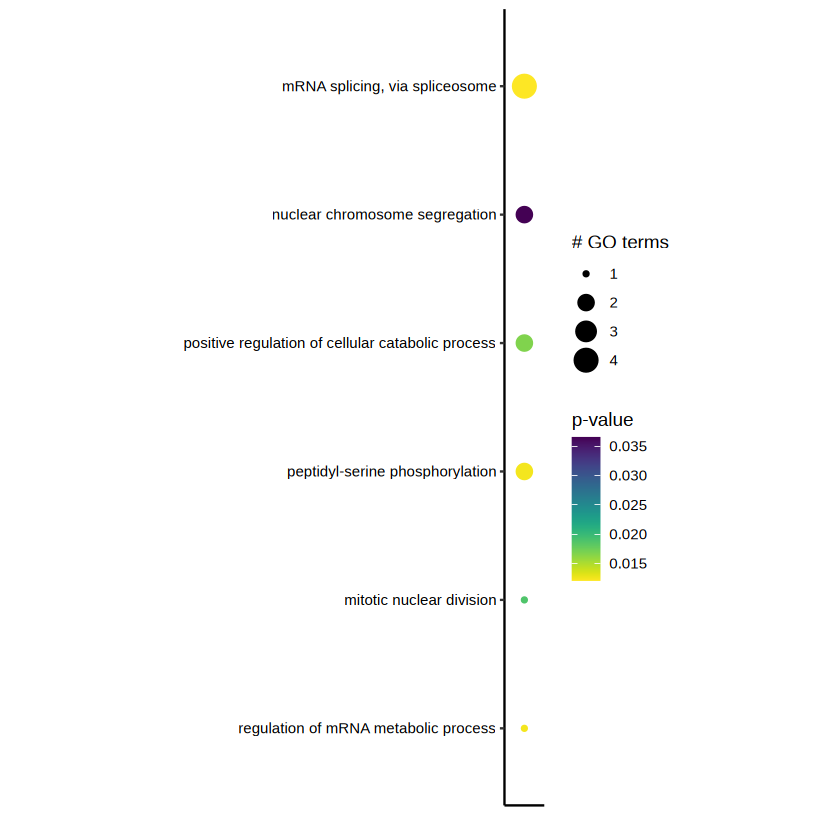

In [4]:
# order according to members_count
SSA_up <- SSA_up[order(SSA_up$members_count),]
SSA_up$description <- factor(SSA_up$description, levels=c(SSA_up$description))

SSA_down <- SSA_down[order(SSA_down$members_count),]
SSA_down$description <- factor(SSA_down$description, levels=c(SSA_down$description))

# plot
library(viridis)
plot_up <- ggplot(SSA_up, aes(2, description)) +
  geom_tile(fill="white") +
  geom_point(aes(color=pval, size=members_count)) +
  scale_size_continuous(name = "# GO terms", breaks=c(1, 2, 3, 4)) +
  scale_color_viridis(name = "p-value", direction=-1) +
  theme_classic() +
  theme(aspect.ratio=20, axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.text.y=element_text(color='black')) +
  xlab('') + ylab('') 
plot_up

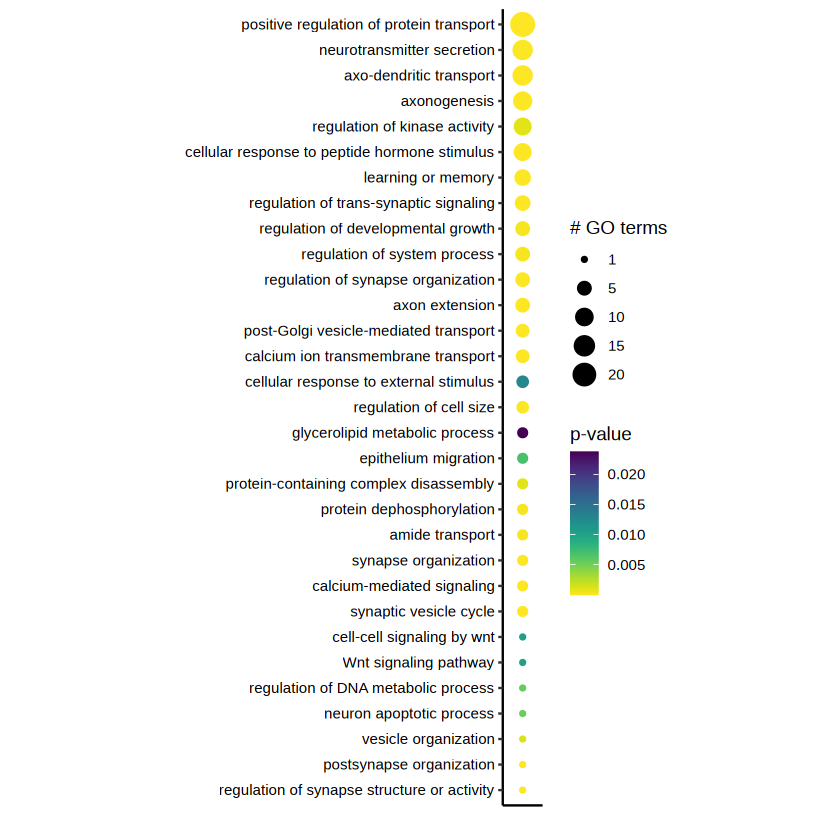

In [5]:
plot_down <- ggplot(SSA_down, aes(2, description)) +
  geom_tile(fill="white") +
  geom_point(aes(color=pval, size=members_count)) +
  scale_size_continuous(name = "# GO terms", breaks=c(1, 5, 10, 15, 20)) +
  scale_color_viridis(name = "p-value", direction=-1) +
  theme_classic() +
  theme(aspect.ratio=20, axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.text.y=element_text(color='black')) +
  xlab('') + ylab('') 
plot_down

In [6]:
ggsave('../results/ORA/output_GO_Figure/UP/SSA_mashR_up.pdf', plot = plot_up, height=3.8, width = 5)

ggsave('../results/ORA/output_GO_Figure/DOWN/SSA_mashR_down.pdf', plot = plot_down, height=6, width = 5)

## ORA up vs downregulated genes in all cell types

In [28]:
# setting the organism: human
library(org.Hs.eg.db)
#set the organism
organism <- org.Hs.eg.db


### get enriched terms biological process for each cell type

######## DE genes AGE up only
ORA_all_Age_up <- list()
for (celltype in celltypes){
  sig_DE_genes <- up[[celltype]]$ID
  all_genes_in_celltype <- DE_genes_Age[[celltype]]$ID
  ego <- enrichGO(gene = sig_DE_genes,
                  universe = all_genes_in_celltype,
                  OrgDb = organism,
                  keyType = 'SYMBOL',
                  ont = "BP",
                  pAdjustMethod = "none",
                  pvalueCutoff  = 1, #set this to 1 otherwise plotting won't work because of applied filter
                  qvalueCutoff  = 1, #set this to 1 otherwise plotting won't work because of applied filter
                  readable = F)
  ORA_all_Age_up[[celltype]] <- ego
}

In [29]:
######## DE genes AGE down only
ORA_all_Age_down <- list()
for (celltype in celltypes){
  sig_DE_genes <- down[[celltype]]$ID
  all_genes_in_celltype <- DE_genes_Age[[celltype]]$ID
  ego <- enrichGO(gene =  sig_DE_genes,
                  universe = all_genes_in_celltype,
                  OrgDb = organism,
                  keyType = 'SYMBOL',
                  ont = "BP",
                  pAdjustMethod = "none",
                  pvalueCutoff  = 1, #set this to 1 otherwise plotting won't work because of applied filter
                  qvalueCutoff  = 1, #set this to 1 otherwise plotting won't work because of applied filter
                  readable = F)
  ORA_all_Age_down[[celltype]] <- ego
}

In [30]:
###### filter processes by "minimum 5% of DE genes need to represent this term"
### then adjust p-value

ORA_all_Age_up_filtered_p_adjust <- list()
for (celltype in celltypes){
  n_DE_genes <- length(up[[celltype]]$ID)
  tmp <- ORA_all_Age_up[[celltype]]
  filtered <- dplyr::filter(tmp@result, Count >= 0.05 * n_DE_genes)
  if (dim(filtered)[1] < 1 ){next}
  else {
    p_adjusted <- p.adjust(filtered$pvalue, method = 'fdr', n = length(filtered$pvalue))
    filtered$p.adjust <- p_adjusted
    ORA_all_Age_up_filtered_p_adjust[[celltype]] <- tmp
    ORA_all_Age_up_filtered_p_adjust[[celltype]]@result <- filtered
  }
}
#View(ORA_all_Age_up_filtered_p_adjust[['OPC']]@result)


ORA_all_Age_down_filtered_p_adjust <- list()
for (celltype in celltypes){
  n_DE_genes <- length(down[[celltype]]$ID)
  tmp <- ORA_all_Age_down[[celltype]]
  filtered <- dplyr::filter(tmp@result, Count >= 0.05 * n_DE_genes)
  if (dim(filtered)[1] < 1 ){next}
  else {
    p_adjusted <- p.adjust(filtered$pvalue, method = 'fdr', n = length(filtered$pvalue))
    filtered$p.adjust <- p_adjusted
    ORA_all_Age_down_filtered_p_adjust[[celltype]] <- tmp
    ORA_all_Age_down_filtered_p_adjust[[celltype]]@result <- filtered
  }
}
#View(ORA_all_Age_down_filtered_p_adjust[['OPC']]@result)

ORA_all_Age_up_result <- list()
for (celltype in names(ORA_all_Age_up_filtered_p_adjust)){
  tmp <- ORA_all_Age_up_filtered_p_adjust[[celltype]]@result
  ORA_all_Age_up_result[[celltype]] <- tmp
}

ORA_all_Age_down_result <- list()
for (celltype in names(ORA_all_Age_down_filtered_p_adjust)){
  tmp <- ORA_all_Age_down_filtered_p_adjust[[celltype]]@result
  ORA_all_Age_down_result[[celltype]] <- tmp
}

In [31]:
# filter for p-adjust < 0.05
sig_ORA_all_Age_up_result<- list()
for (celltype in names(ORA_all_Age_up_result)){
    tmp <- ORA_all_Age_up_result[[celltype]]
    tmp2 <- dplyr::filter(tmp, p.adjust < 0.05 )
    if (dim(tmp2)[1] <1){next}
    sig_ORA_all_Age_up_result[[celltype]] <- tmp2
}

#View(sig_ORA_all_Age_up_result[['OPC']])


sig_ORA_all_Age_down_result<- list()
for (celltype in names(ORA_all_Age_down_result)){
    tmp <- ORA_all_Age_down_result[[celltype]]
    tmp2 <- dplyr::filter(tmp, p.adjust < 0.05 )
    if (dim(tmp2)[1] <1){next}
    sig_ORA_all_Age_down_result[[celltype]] <- tmp2
}

In [32]:
library(writexl)
write_xlsx(sig_ORA_all_Age_up_result, path = "../results/ORA/ORA_up_clusterProfiler_output_sig.xlsx", col_names = TRUE)
write_xlsx(sig_ORA_all_Age_down_result, path = "../results/ORA/ORA_down_clusterProfiler_output_sig.xlsx", col_names = TRUE)

In [15]:
# extract the significant terms for semantic similarity analysis
head(sig_ORA_all_Age_up_result[['OPC']])

# prep for tsv extraction (input for GO-Figure!)
for (celltype in names(sig_ORA_all_Age_up_result)){
    tmp <- sig_ORA_all_Age_up_result[[celltype]]  %>% dplyr::select(c('ID', 'p.adjust'))
    write.table(tmp, paste0('../results/ORA/input_GO_Figure/',celltype, '_UP.tsv'), quote=FALSE, sep='\t', col.names = F, row.names = F)
}

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0097009,GO:0097009,energy homeostasis,4/57,37/7989,0.0001290807,0.01962027,0.1707942,ALK/FOXO1/DLL1/ACACB,4
GO:0042593,GO:0042593,glucose homeostasis,5/57,114/7989,0.0012562749,0.03444696,0.2090683,PYGL/TIAM1/ABCC8/FOXO1/TSC22D4,5
GO:0033500,GO:0033500,carbohydrate homeostasis,5/57,115/7989,0.0013062981,0.03444696,0.2090683,PYGL/TIAM1/ABCC8/FOXO1/TSC22D4,5
GO:0007169,GO:0007169,transmembrane receptor protein tyrosine kinase signaling pathway,8/57,307/7989,0.0013883772,0.03444696,0.2090683,ALK/TXNIP/APOD/HAP1/HIP1/TIAM1/FOXO1/DLL1,8
GO:0050708,GO:0050708,regulation of protein secretion,5/57,119/7989,0.0015212567,0.03444696,0.2090683,MYOM1/DNAJC1/TIAM1/ABCC8/FOXO1,5
GO:0031589,GO:0031589,cell-substrate adhesion,6/57,177/7989,0.0015452818,0.03444696,0.2090683,DOCK5/AJAP1/APOD/TIAM1/PREX1/MKLN1,6


In [16]:
# extract the significant terms for semantic similarity analysis
head(sig_ORA_all_Age_down_result[['OPC']])

# prep for tsv extraction (input for GO-Figure!)
for (celltype in names(sig_ORA_all_Age_down_result)){
    tmp <- sig_ORA_all_Age_down_result[[celltype]]  %>% dplyr::select(c('ID', 'p.adjust'))
    write.table(tmp, paste0('../results/ORA/input_GO_Figure/',celltype, '_DOWN.tsv'), quote=FALSE, sep='\t', col.names = F, row.names = F)
}

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0034330,GO:0034330,cell junction organization,24/130,464/7989,3.444256e-07,3.584228e-05,0.0003399434,GPR158/CAP2/YWHAZ/CNTN5/PTPRO/GABRB2/CAMKV/HOPX/EPB41L3/GRIN2B/HOMER1/UNC13C/THBS2/HSPA8/FGF13/CNTNAP2/GABRA1/FRRS1L/RAC1/ACTB/CDH18/SYNDIG1/VEGFA/CDKL5,24
GO:0022898,GO:0022898,regulation of transmembrane transporter activity,12/130,118/7989,4.082208e-07,3.584228e-05,0.0003399434,UTRN/SCN3B/CABP1/CALM1/ATP1B1/HOMER1/FGF13/FKBP1A/CALM2/VAMP2/ACTB/TMSB4X,12
GO:0032409,GO:0032409,regulation of transporter activity,12/130,125/7989,7.653369e-07,3.584228e-05,0.0003399434,UTRN/SCN3B/CABP1/CALM1/ATP1B1/HOMER1/FGF13/FKBP1A/CALM2/VAMP2/ACTB/TMSB4X,12
GO:1904062,GO:1904062,regulation of monoatomic cation transmembrane transport,13/130,149/7989,7.846445e-07,3.584228e-05,0.0003399434,UTRN/SCN3B/CABP1/CALM1/GRIN2B/ATP1B1/HOMER1/FGF13/FKBP1A/CALM2/GRIN1/VAMP2/TMSB4X,13
GO:0034765,GO:0034765,regulation of monoatomic ion transmembrane transport,15/130,203/7989,9.143439e-07,3.584228e-05,0.0003399434,UTRN/KCNH5/SCN3B/CABP1/KCNJ3/CALM1/GRIN2B/ATP1B1/HOMER1/FGF13/FKBP1A/CALM2/GRIN1/VAMP2/TMSB4X,15
GO:2001257,GO:2001257,regulation of cation channel activity,8/130,52/7989,1.633846e-06,4.442154e-05,0.0004213128,CABP1/CALM1/HOMER1/FGF13/FKBP1A/CALM2/VAMP2/TMSB4X,8


## perform semantic similarity analysis

perform semantic similarity analysis to reduce redundancies of GO-terms using GO-Figure! <br>
see script 01_b_GO_Figure_all_cell_types_results.sh

In [7]:
# read in results from semantic similarity analysis by GO-Figure
celltypes_up <- c("Astro_PP", "Exc_L2-3", "Exc_L4-6_1", "Exc_L4-6_2", "Exc_L4-6_3", "In_PVALB_Ba",
                  "In_SST", "In_VIP", "Microglia", "Oligodendrocyte", "OPC")

celltypes_down <- c("Astro_FB", "Astro_PP", "Endothelial", "Exc_L2-3", "Exc_L3-5", "Exc_L4-6_1",
                    "Exc_L4-6_2", "Exc_L4-6_3", "Exc_L5-6_1", "In_LAMP5_1", "In_LAMP5_2",
                    "In_PVALB_Ba", "In_PVALB_Ch", "In_RELN", "In_SST", "In_VIP", "Microglia",
                    "Oligodendrocyte", "OPC")


SSA_up_list <- list()
SSA_down_list <- list()

for (celltype in celltypes_up){
    SSA_up_list[[celltype]] <- readr::read_tsv(paste0('../results/ORA/output_GO_Figure/UP/biological_process_ORA_UP_',celltype,'.tsv'))
}

for (celltype in celltypes_down){
    SSA_down_list[[celltype]] <- readr::read_tsv(paste0('../results/ORA/output_GO_Figure/DOWN/biological_process_ORA_DOWN_',celltype,'.tsv'))
}

Rows: 11 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): description, legend, members, representative
dbl (8): dotCount, x, y, frequency, colour, size, pval, user

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): description, legend, members, representative
dbl (8): dotCount, x, y, frequency, colour, size, pval, user

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): description, legend, members, representative
dbl (8): dotCount, x, y, frequency, colour, size, pval

In [8]:
# count how many GO-terms contributed to each summarised GO-term

for (celltype in names(SSA_up_list)){
    tmp <- SSA_up_list[[celltype]]
    tmp$members_count <- NA
    for (row in 1:length(tmp$members_count)){
        tmp2 <- tmp$members[row]
        tmp$members_count[row] <- length(str_split_1(tmp2, ','))
        # order according to members_count
        tmp <- tmp[order(tmp$members_count),]
        tmp$description <- factor(tmp$description, levels=c(tmp$description))
        SSA_up_list[[celltype]] <- tmp }
}

for (celltype in names(SSA_down_list)){
    tmp <- SSA_down_list[[celltype]]
    tmp$members_count <- NA
    for (row in 1:length(tmp$members_count)){
        tmp2 <- tmp$members[row]
        tmp$members_count[row] <- length(str_split_1(tmp2, ','))
        # order according to members_count
        tmp <- tmp[order(tmp$members_count),]
        tmp$description <- factor(tmp$description, levels=c(tmp$description))
        SSA_down_list[[celltype]] <- tmp }
}

In [9]:
head(SSA_down_list[['Astro_PP']])

dotCount,x,y,frequency,colour,size,pval,description,legend,members,representative,user,members_count
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<dbl>,<int>
5,-0.2362493,-0.54698854,1.4066447,-4.204242,0.6931472,6.248241e-05,glutamate receptor signaling pathway,5. glutamate receptor signaling pathway,['GO:0007215'],GO:0007215,0,1
15,-0.6158455,-0.91972469,0.9367972,-1.971660,0.6931472,1.067431e-02,G protein-coupled receptor signaling pathway,15. G protein-coupled receptor signaling pathway,['GO:0007186'],GO:0007186,0,1
17,1.1811165,0.42655832,1.3324206,-1.854207,0.6931472,1.398921e-02,inflammatory response,17. inflammatory response,['GO:0006954'],GO:0006954,0,1
19,0.6791624,0.80109677,1.6528472,-1.753628,0.6931472,1.763485e-02,postsynapse organization,19. postsynapse organization,['GO:0099173'],GO:0099173,0,1
22,-0.7622111,-0.03281206,1.7044629,-1.540318,0.6931472,2.881919e-02,regulation of synapse structure or activity,22. regulation of synapse structure or activity,['GO:0050803'],GO:0050803,0,1
25,1.1066571,-0.24614332,1.5431653,-1.469217,0.6931472,3.394555e-02,epithelial cell proliferation,25. epithelial cell proliferation,['GO:0050673'],GO:0050673,0,1


## Extended Data Fig.7

In [10]:
# plot
library(viridis)

breaks_up <- list()
for (celltype in names(SSA_up_list)){
    min <- min(SSA_up_list[[celltype]]$members_count)
    max <- max(SSA_up_list[[celltype]]$members_count)
    breaks_up[[celltype]] <- round(seq(min, max, length.out = 4), digits = 0)
}

breaks_down <- list()
for (celltype in names(SSA_down_list)){
    min <- min(SSA_down_list[[celltype]]$members_count)
    max <- max(SSA_down_list[[celltype]]$members_count)
    breaks_down[[celltype]] <- round(seq(min, max, length.out = 4), digits = 0)
}

In [11]:
fig_list_up <- list()
for (celltype in names(SSA_up_list)){
    hght <- length(SSA_up_list[[celltype]]$description)/5
    if (hght < 3.5){
        hght <- 3.5}
    fig_list_up[[celltype]] <- ggplot(SSA_up_list[[celltype]], aes(2, description)) +
    geom_tile(fill="white") +
    geom_point(aes(color=pval, size=members_count)) +
    scale_size_continuous(name = "# GO terms", breaks=breaks_up[[celltype]]) +
    scale_color_viridis(name = "p-value", direction=-1) + theme_classic() +
    theme(aspect.ratio=10, axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
          axis.text.y=element_text(color='black'), plot.title=element_text(hjust=0.5, face='bold')) +
    xlab('') + ylab('') +ggtitle(celltype)
ggsave(paste0('../results/ORA/output_GO_Figure/UP/SSA_', celltype, '_up.pdf'), plot = fig_list_up[[celltype]], height=hght, width = 7)
}

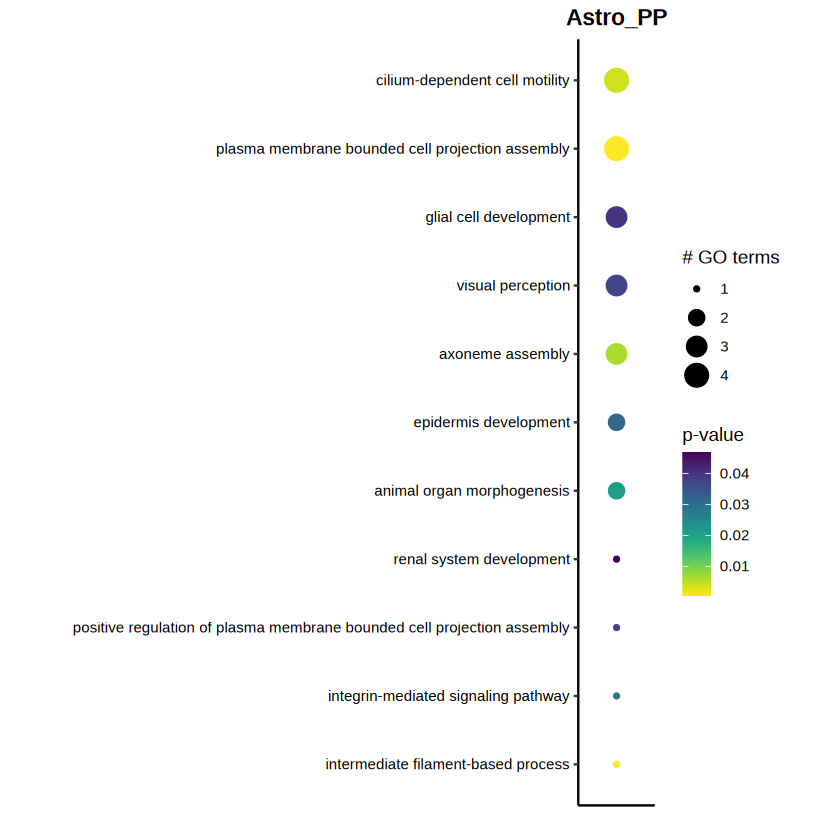

In [12]:
options(repr.plot.width=7, repr.plot.height=7)
ggplot(SSA_up_list[['Astro_PP']], aes(2, description)) +
    geom_tile(fill="white") +
    geom_point(aes(color=pval, size=members_count)) +
    scale_size_continuous(name = "# GO terms", breaks=breaks_up[['Astro_PP']]) +
    scale_color_viridis(name = "p-value", direction=-1) + theme_classic() +
    theme(aspect.ratio=10, axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
          axis.text.y=element_text(color='black'), plot.title=element_text(hjust=0.5, face='bold')) +
    xlab('') + ylab('') +ggtitle('Astro_PP')

In [13]:
fig_list_down <- list()
for (celltype in names(SSA_down_list)){
    hght <- length(SSA_down_list[[celltype]]$description)/5
    if (hght < 3.5){
        hght <- 3.5}
    fig_list_down[[celltype]] <- ggplot(SSA_down_list[[celltype]], aes(2, description)) +
    geom_tile(fill="white") +
    geom_point(aes(color=pval, size=members_count)) +
    scale_size_continuous(name = "# GO terms", breaks=breaks_down[[celltype]]) +
    scale_color_viridis(name = "p-value", direction=-1) + theme_classic() +
    theme(aspect.ratio=10, axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
          axis.text.y=element_text(color='black'), plot.title=element_text(hjust=0.5, face='bold')) +
    xlab('') + ylab('') +ggtitle(celltype)
    ggsave(paste0('../results/ORA/output_GO_Figure/DOWN/SSA_', celltype, '_down.pdf'), plot = fig_list_down[[celltype]], height=hght, width = 7)
}

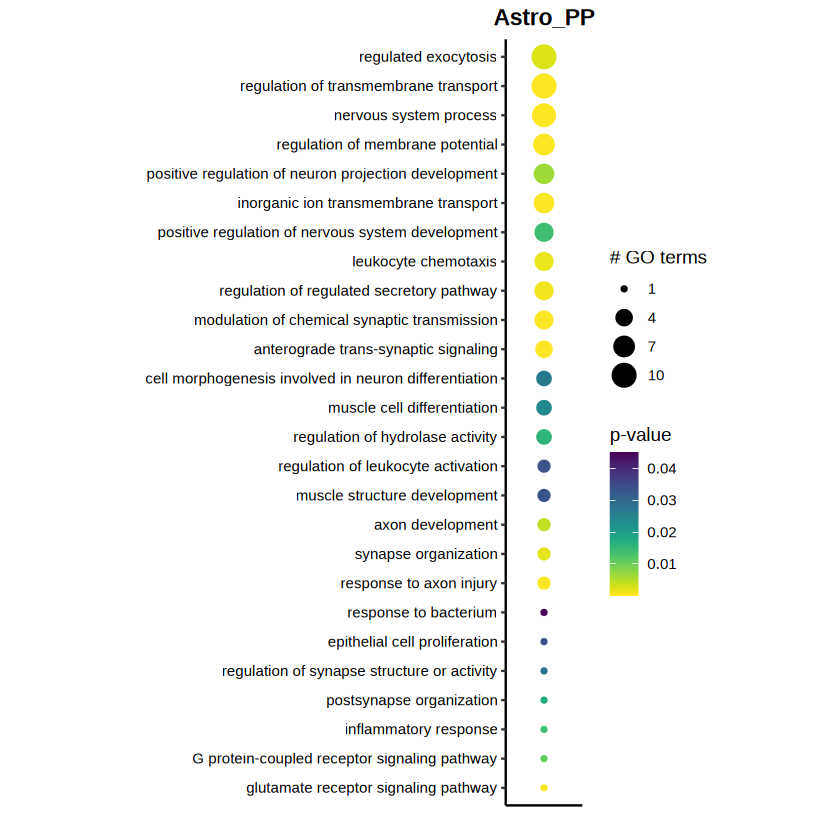

In [14]:
options(repr.plot.width=7, repr.plot.height=7)
ggplot(SSA_down_list[['Astro_PP']], aes(2, description)) +
    geom_tile(fill="white") +
    geom_point(aes(color=pval, size=members_count)) +
    scale_size_continuous(name = "# GO terms", breaks=breaks_down[['Astro_PP']]) +
    scale_color_viridis(name = "p-value", direction=-1) + theme_classic() +
    theme(aspect.ratio=10, axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
          axis.text.y=element_text(color='black'), plot.title=element_text(hjust=0.5, face='bold')) +
    xlab('') + ylab('') +ggtitle('Astro_PP')

# Disease Enrichment analysis

In [3]:
####### Over-representation analysis for disease ontology
#######

# ensembl IDs need to be first mapped to entrez IDs using biomaRt
# the entrez_IDs which are a list need to be formated (within the loop)
library(biomaRt)
library(DOSE)
ensembl <- useEnsembl(biomart = "ensembl", 
                      dataset = "hsapiens_gene_ensembl", version='98')

#to format correctly the output of getBM(): as.vector(as.character(unlist(getBM()))))

DiseaseOntologies_Age_up <- list()
for (celltype in names(DE_genes_Age)){
  sig_DE_genes <- up[[celltype]]$ID
  sig_DE_genes_entrez_ID <-as.vector(as.character(
    unlist(getBM(filters= "hgnc_symbol", attributes= c("entrezgene_id"),values=
                   sig_DE_genes,mart= ensembl))))
  all_genes_in_celltype <- DE_genes_Age[[celltype]]$ID
  all_genes_in_celltype_entrez_ID <- as.vector(as.character(
    unlist(getBM(filters= "hgnc_symbol", attributes= c("entrezgene_id"),values=
                   all_genes_in_celltype,mart= ensembl))))
  DO <- enrichDO(gene =  sig_DE_genes_entrez_ID,
                 universe = all_genes_in_celltype_entrez_ID,
                 ont = "DO",
                 pAdjustMethod = "none",
                 pvalueCutoff  = 1, #set this to 1 otherwise plotting won't work because of applied filter
                 qvalueCutoff  = 1, #set this to 1 otherwise plotting won't work because of applied filter
                 readable = TRUE, 
                 minGSSize     = 5,
                 maxGSSize     = 500)
  DiseaseOntologies_Age_up[[celltype]] <- DO
}

DiseaseOntologies_Age_down <- list()
for (celltype in names(DE_genes_Age)){
  sig_DE_genes <- down[[celltype]]$ID
  sig_DE_genes_entrez_ID <-as.vector(as.character(
    unlist(getBM(filters= "hgnc_symbol", attributes= c("entrezgene_id"),values=
                   sig_DE_genes,mart= ensembl))))
  all_genes_in_celltype <- DE_genes_Age[[celltype]]$ID
  all_genes_in_celltype_entrez_ID <- as.vector(as.character(
    unlist(getBM(filters= "hgnc_symbol", attributes= c("entrezgene_id"),values=
                   all_genes_in_celltype,mart= ensembl))))
  DO <- enrichDO(gene =  sig_DE_genes_entrez_ID,
                 universe = all_genes_in_celltype_entrez_ID,
                 ont = "DO",
                 pAdjustMethod = "none",
                 pvalueCutoff  = 1, #set this to 1 otherwise plotting won't work because of applied filter
                 qvalueCutoff  = 1, #set this to 1 otherwise plotting won't work because of applied filter
                 readable = TRUE, 
                 minGSSize     = 5,
                 maxGSSize     = 500)
  DiseaseOntologies_Age_down[[celltype]] <- DO
}



DOSE v3.28.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609




In [4]:
# filter for minimum 5% of DE genes and minimum 2 genes per term, then perform correction
# n_DE_genes only refers to either the up OR downregulated genes 
# for a cell type to be included in any further downstream analysis (figure) it has to have minimum 1 DO term 

# n_DE_genes <- length(DE_genes_Age_w_PC1[[celltype]]$ensembl_gene_id)

up_DiseaseOntologies_Age_p_adjust <- list()
for (celltype in names(DE_genes_Age)){
  n_DE_genes <- length(up[[celltype]]$ID)
  tmp <- DiseaseOntologies_Age_up[[celltype]]
  filtered <- dplyr::filter(tmp@result, Count >= 0.05 * n_DE_genes)
  filtered <- dplyr::filter(filtered, Count >1)
  if (dim(filtered)[1] < 1 ){next}
  else {
    p_adjusted <- p.adjust(filtered$pvalue, method = 'fdr', n = length(filtered$pvalue))
    filtered$p.adjust <- p_adjusted
    up_DiseaseOntologies_Age_p_adjust[[celltype]] <- tmp
    up_DiseaseOntologies_Age_p_adjust[[celltype]]@result <- filtered
  }
}

#length(DE_genes_Age_w_PC1[[celltype]]$ensembl_gene_id)


down_DiseaseOntologies_Age_p_adjust <- list()
for (celltype in names(DE_genes_Age)){
  n_DE_genes <- length(down[[celltype]]$ID)
  tmp <- DiseaseOntologies_Age_down[[celltype]]
  filtered <- dplyr::filter(tmp@result, Count >= 0.05 * n_DE_genes)
  filtered <- dplyr::filter(filtered, Count >1)
  if (dim(filtered)[1] < 1 ){next}
  else {
    p_adjusted <- p.adjust(filtered$pvalue, method = 'fdr', n = length(filtered$pvalue))
    filtered$p.adjust <- p_adjusted
    down_DiseaseOntologies_Age_p_adjust[[celltype]] <- tmp
    down_DiseaseOntologies_Age_p_adjust[[celltype]]@result <- filtered
  }
}

#head(down_DiseaseOntologies_Age_p_adjust[['OPC']]@result)

In [5]:
# filter for p-adjust < 0.05
sig_DO_Age_up_result <- list()
for (celltype in names(up_DiseaseOntologies_Age_p_adjust)){
    tmp <- up_DiseaseOntologies_Age_p_adjust[[celltype]]@result
    tmp2 <- dplyr::filter(tmp, p.adjust < 0.05 )
    if (dim(tmp2)[1] <1){next}
    sig_DO_Age_up_result[[celltype]] <- tmp2
}

#View(sig_ORA_all_Age_up_result[['OPC']])


sig_DO_Age_down_result <- list()
for (celltype in names(down_DiseaseOntologies_Age_p_adjust)){
    tmp <- down_DiseaseOntologies_Age_p_adjust[[celltype]]@result
    tmp2 <- dplyr::filter(tmp, p.adjust < 0.05 )
    if (dim(tmp2)[1] <1){next}
    sig_DO_Age_down_result[[celltype]] <- tmp2
}

In [36]:
library(writexl)
write_xlsx(sig_DO_Age_up_result, path = "../results/ORA/ORA_up_DiseaseEnrich_output_sig.xlsx", col_names = TRUE)
write_xlsx(sig_DO_Age_down_result, path = "../results/ORA/ORA_down_DiseaseEnrich_output_sig.xlsx", col_names = TRUE)

In [6]:
#Heatmap with Count representing colour and * representing p.adjust
#only cell types with minimum 1 DO term are included

merged_DO_down <- as.data.frame(matrix(ncol=4, nrow=0))
colnames(merged_DO_down) <- c('Description', 'Count', 'p.adjust', 'celltype')
for (celltype in names(down_DiseaseOntologies_Age_p_adjust)){
  tmp <- down_DiseaseOntologies_Age_p_adjust[[celltype]]@result
  tmp2 <- tmp[,c('Description', 'Count', 'p.adjust')]
  tmp2$celltype <- celltype
  merged_DO_down <- rbind(merged_DO_down, tmp2)
}

# fill empty values with NA
# if a cell type does not have DO term put NA
# if DO term is NA put p-value 1
formated_DO_down <- as.data.frame(complete(merged_DO_down, celltype, Description))
formated_DO_down$p.adjust[which(is.na(formated_DO_down$p.adjust))] <- 1

# get DO terms that are signficant in at least one cell type
sig_DO_Terms_down <- c()
#collect a list of signficant GO-terms - combine for all celltypes
for (celltype in names(down_DiseaseOntologies_Age_p_adjust)){
  tmp <- down_DiseaseOntologies_Age_p_adjust[[celltype]]@result
  tmp2 <- tmp[,c('Description', 'Count', 'p.adjust')]
  tmp3 <- subset(tmp2, p.adjust < 0.05)
  sig_DO_Terms_down <- c(sig_DO_Terms_down, tmp3$Description)
}

# subset dataframe for DO terms signficant in at least one cell type
DO_final_down <- formated_DO_down[formated_DO_down$Description %in% unique(sig_DO_Terms_down),]
#unique(sig_DO_Terms_down)
#length(unique(sig_DO_Terms_down))



In [7]:
#only cell types with minimum 1 DO term are included

merged_DO_up <- as.data.frame(matrix(ncol=4, nrow=0))
colnames(merged_DO_up) <- c('Description', 'Count', 'p.adjust', 'celltype')
for (celltype in names(up_DiseaseOntologies_Age_p_adjust)){
  tmp <- up_DiseaseOntologies_Age_p_adjust[[celltype]]@result
  tmp2 <- tmp[,c('Description', 'Count', 'p.adjust')]
  tmp2$celltype <- celltype
  merged_DO_up <- rbind(merged_DO_up, tmp2)
}

# fill empty values with NA
# if a cell type does not have DO term put NA
# if DO term is NA put p-value 1
formated_DO_up <- as.data.frame(complete(merged_DO_up, celltype, Description))
formated_DO_up$p.adjust[which(is.na(formated_DO_up$p.adjust))] <- 1

# get DO terms that are signficant in at least one cell type
sig_DO_Terms_up <- c()
#collect a list of signficant GO-terms - combine for all celltypes
for (celltype in names(up_DiseaseOntologies_Age_p_adjust)){
  tmp <- up_DiseaseOntologies_Age_p_adjust[[celltype]]@result
  tmp2 <- tmp[,c('Description', 'Count', 'p.adjust')]
  tmp3 <- subset(tmp2, p.adjust < 0.05)
  sig_DO_Terms_up <- c(sig_DO_Terms_up, tmp3$Description)
}

# subset dataframe for DO terms signficant in at least one cell type
DO_final_up <- formated_DO_up[formated_DO_up$Description %in% unique(sig_DO_Terms_up),]
#unique(sig_DO_Terms_up)
#length(unique(sig_DO_Terms_up))

## Fig. 4 - plot only brain-related diseases

### down

In [8]:
unique(DO_final_down$Description)

[1] "acquired metabolic disease"                
 [2] "alcohol use disorder"                      
 [3] "Alzheimer's disease"                       
 [4] "artery disease"                            
 [5] "autism spectrum disorder"                  
 [6] "autistic disorder"                         
 [7] "benign neoplasm"                           
 [8] "bone disease"                              
 [9] "brain disease"                             
[10] "brain ischemia"                            
[11] "cardiomyopathy"                            
[12] "cognitive disorder"                        
[13] "congestive heart failure"                  
[14] "dementia"                                  
[15] "developmental and epileptic encephalopathy"
[16] "developmental disorder of mental health"   
[17] "electroclinical syndrome"                  
[18] "endocrine gland cancer"                    
[19] "endocrine system disease"                  
[20] "epilepsy"                                  
[21] "eye disease"                               
[22] "female reproductive organ cancer"          
[23] "focal epilepsy"                            
[24] "heart disease"                             
[25] "hypertension"                              
[26] "intrinsic cardiomyopathy"                  
[27] "ischemia"                                  
[28] "lower respiratory tract disease"           
[29] "lung disease"                              
[30] "male reproductive organ cancer"            
[31] "melanoma"                                  
[32] "mood disorder"                             
[33] "movement disease"                          
[34] "nervous system cancer"                     
[35] "neuropathy"                                
[36] "nutrition disease"                         
[37] "obesity"                                   
[38] "overnutrition"                             
[39] "Parkinson's disease"                       
[40] "peripheral nervous system disease"         
[41] "pervasive developmental disorder"          
[42] "prostate cancer"                           
[43] "psychotic disorder"                        
[44] "respiratory system disease"                
[45] "schizophrenia"                             
[46] "squamous cell carcinoma"                   
[47] "substance abuse"                           
[48] "substance-related disorder"                
[49] "synucleinopathy"                           
[50] "tauopathy"                                 
[51] "temporal lobe epilepsy"                    
[52] "thyroid gland cancer"                      
[53] "thyroid gland carcinoma"                   
[54] "toxic encephalopathy"                      
[55] "vascular disease"                          
[56] "visual epilepsy"

In [9]:
# select brain-related diseases
brain_disease_down <- c('brain disease', "Alzheimer's disease", 'tauopathy', 'dementia',
                                             "Parkinson's disease", 'synucleinopathy', 'movement disease',
                                             'cognitive disorder', 'developmental disorder of mental health', 
                                             'neuropathy', 'schizophrenia', 'psychotic disorder', 'mood disorder',
                                             'autism spectrum disorder', 'autistic disorder', 'alcohol use disorder',
                                             'substance abuse', 'substance-related disorder', 'pervasive developmental disorder',
                                             'epilepsy', 'temporal lobe epilepsy', 'focal epilepsy', 'developmental and epileptic encephalopathy', 
                                             'visual epilepsy', 'electroclinical syndrome', 'toxic encephalopathy',
                                             'brain ischemia')
brain_diseases_down_df <- DO_final_down[DO_final_down$Description %in% brain_disease_down,]




In [10]:
#find cell types that do not have enrichment for any brain-related disorder
cts_without_brain_disorder <- c()
for (celltype in unique(brain_diseases_down_df$celltype)){
    tmp <- brain_diseases_down_df[brain_diseases_down_df$celltype == celltype,]
    if (sum(tmp$Count, na.rm=TRUE) < 1){
        cts_without_brain_disorder <- c(cts_without_brain_disorder, celltype)}}

cts_without_brain_disorder

# remove
brain_diseases_down_df <- subset(brain_diseases_down_df, !(celltype %in% cts_without_brain_disorder ))

[1] "Exc_L5-6_2"

In [11]:
# sort
brain_diseases_down_df$Description <- factor(brain_diseases_down_df$Description, 
                                    levels=rev(c('brain disease', "Alzheimer's disease", 'tauopathy', 'dementia',
                                             "Parkinson's disease", 'synucleinopathy', 'movement disease',
                                             'cognitive disorder', 'developmental disorder of mental health', 
                                             'neuropathy', 'schizophrenia', 'psychotic disorder', 'mood disorder',
                                             'autism spectrum disorder', 'autistic disorder', 'alcohol use disorder',
                                             'substance abuse', 'substance-related disorder', 'pervasive developmental disorder',
                                             'epilepsy', 'temporal lobe epilepsy', 'focal epilepsy', 'developmental and epileptic encephalopathy', 
                                             'visual epilepsy', 'electroclinical syndrome', 'toxic encephalopathy',
                                             'brain ischemia')))

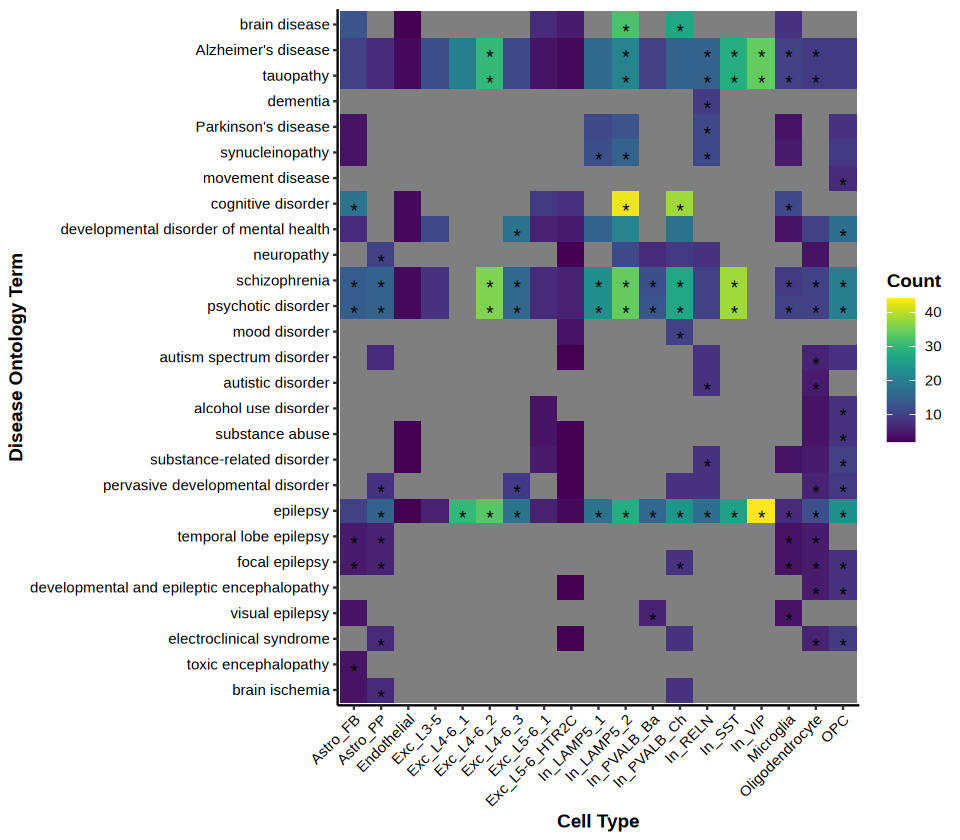

In [12]:
library(viridis)
options(repr.plot.width=8, repr.plot.height=7)
ggplot(brain_diseases_down_df, aes(celltype, Description, fill= Count, label = ifelse(p.adjust < 0.05, "*", ""))) + 
  geom_tile() + theme_classic() + geom_text(vjust = 1, hjust = 0.5) +
  scale_fill_viridis(discrete=FALSE) +
  #scale_fill_gradient2("Count", low = "blue", mid = "white", high = "red", na.value = "grey70") +
  ylab("Disease Ontology Term") +
  xlab("Cell Type") + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, color="black"), 
                            axis.text.y = element_text(color='black'), axis.title = element_text(face='bold'), 
                            legend.title = element_text(face='bold'))
ggsave('../figures/Disease_enrich_ORA_down_brain_related_diseases_dreamlet.pdf', plot = last_plot(), height=6.5, width = 7)

### up

In [13]:
unique(DO_final_up$Description)

[1] "adenoma"                                     
 [2] "allergic asthma"                             
 [3] "allergic disease"                            
 [4] "artery disease"                              
 [5] "arthritis"                                   
 [6] "auditory system disease"                     
 [7] "autoimmune disease"                          
 [8] "autoimmune disease of endocrine system"      
 [9] "autoimmune disease of gastrointestinal tract"
[10] "benign neoplasm"                             
[11] "bipolar disorder"                            
[12] "bone disease"                                
[13] "bone inflammation disease"                   
[14] "bone marrow cancer"                          
[15] "bullous skin disease"                        
[16] "celiac disease"                              
[17] "cell type benign neoplasm"                   
[18] "central nervous system cancer"               
[19] "cholangitis"                                 
[20] "chronic asthma"                              
[21] "chronic obstructive pulmonary disease"       
[22] "connective tissue disease"                   
[23] "Coronavirus infectious disease"              
[24] "demyelinating disease"                       
[25] "dermatitis"                                  
[26] "diabetes"                                    
[27] "endocrine gland cancer"                      
[28] "endocrine system disease"                    
[29] "epidermolysis bullosa"                       
[30] "esophageal cancer"                           
[31] "extrinsic asthma"                            
[32] "female reproductive system disease"          
[33] "gastrointestinal system disease"             
[34] "glaucoma"                                    
[35] "glomerulonephritis"                          
[36] "glucose metabolism disease"                  
[37] "hemorrhagic disease"                         
[38] "hepatitis B"                                 
[39] "hepatobiliary system cancer"                 
[40] "hypertension"                                
[41] "integumentary system disease"                
[42] "irritable bowel syndrome"                    
[43] "kidney disease"                              
[44] "kidney failure"                              
[45] "liver cirrhosis"                             
[46] "low tension glaucoma"                        
[47] "lung disease"                                
[48] "male reproductive organ cancer"              
[49] "melanoma"                                    
[50] "mood disorder"                               
[51] "multiple sclerosis"                          
[52] "muscle tissue disease"                       
[53] "myeloid neoplasm"                            
[54] "myositis"                                    
[55] "nephritis"                                   
[56] "nervous system cancer"                       
[57] "obesity"                                     
[58] "obstructive lung disease"                    
[59] "open-angle glaucoma"                         
[60] "organ system benign neoplasm"                
[61] "ovarian cancer"                              
[62] "overnutrition"                               
[63] "pancreas disease"                            
[64] "pancreatic cancer"                           
[65] "pancreatitis"                                
[66] "parasitic helminthiasis infectious disease"  
[67] "parasitic infectious disease"                
[68] "prostate cancer"                             
[69] "prostate carcinoma"                          
[70] "reproductive system disease"                 
[71] "respiratory system cancer"                   
[72] "rheumatoid arthritis"                        
[73] "sensory system disease"                      
[74] "severe acute respiratory syndrome"           
[75] "skin disease"                                
[76] "substance abuse"                             
[77] "substance-related disorder"                

In [14]:
brain_disease_up <- c('demyelinating disease','multiple sclerosis', 'mood disorder', 
                      'bipolar disorder', 'substance-related disorder', 'substance abuse')

brain_diseases_up_df <- DO_final_up[DO_final_up$Description %in% brain_disease_up,]

In [15]:
#find cell types that do not have enrichment for any brain-related disorder
cts_without_brain_disorder <- c()
for (celltype in unique(brain_diseases_up_df$celltype)){
    tmp <- brain_diseases_up_df[brain_diseases_up_df$celltype == celltype,]
    if (sum(tmp$Count, na.rm=TRUE) < 1){
        cts_without_brain_disorder <- c(cts_without_brain_disorder, celltype)}}

cts_without_brain_disorder

# remove
brain_diseases_up_df <- subset(brain_diseases_up_df, !(celltype %in% cts_without_brain_disorder ))

[1] "Astro_FB"       "Astro_PP"       "Exc_L3-5"       "Exc_L4-6_1"    
 [5] "Exc_L4-6_2"     "Exc_L4-6_3"     "Exc_L5-6_2"     "Exc_L5-6_HTR2C"
 [9] "In_LAMP5_1"     "In_LAMP5_2"     "In_PVALB_Ch"    "In_RELN"       
[13] "In_SST"         "OPC"

In [16]:
# sort
brain_diseases_up_df$Description <- factor(brain_diseases_up_df$Description, 
                                           levels= rev(c('demyelinating disease','multiple sclerosis',
                                                         'mood disorder', 'bipolar disorder', 
                                                         'substance-related disorder','substance abuse')))

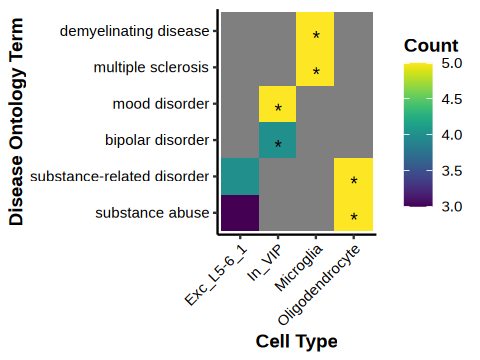

In [24]:
options(repr.plot.width=4, repr.plot.height=3)
ggplot(brain_diseases_up_df, aes(celltype, Description, fill= Count, label = ifelse(p.adjust < 0.05, "*", ""))) + 
  geom_tile() + theme_classic() + geom_text(vjust = 1, hjust = 0.5) +
  scale_fill_viridis(discrete=FALSE) +
  #scale_fill_gradient2("Count", low = "blue", mid = "white", high = "red", na.value = "grey70") +
  ylab("Disease Ontology Term") +
  xlab("Cell Type") + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, color="black"), axis.text.y = element_text(color='black'), axis.title = element_text(face='bold'), legend.title = element_text(face='bold'))

ggsave('../figures/Disease_enrich_ORA_up_brain_related_diseases_dreamlet.pdf', plot = last_plot(), height=2.7, width = 3.3)

## Ext. Data Fig. 8a,b - plot full disease enrichment

In [18]:
# define order of terms
DO_final_down$Description <- factor(DO_final_down$Description, 
                                    levels=rev(c('brain disease', "Alzheimer's disease", 'tauopathy', 'dementia',
                                             "Parkinson's disease", 'synucleinopathy', 'movement disease',
                                             'cognitive disorder', 'developmental disorder of mental health', 
                                             'neuropathy', 'schizophrenia', 'psychotic disorder', 'mood disorder',
                                             'autism spectrum disorder', 'autistic disorder', 'alcohol use disorder',
                                             'substance abuse', 'substance-related disorder', 'pervasive developmental disorder',
                                             'epilepsy', 'temporal lobe epilepsy', 'focal epilepsy', 'developmental and epileptic encephalopathy', 
                                             'visual epilepsy', 'electroclinical syndrome', 'toxic encephalopathy',
                                             'brain ischemia', 'ischemia', 'peripheral nervous system disease',
                                             'vascular disease', 'artery disease', 'hypertension', 'heart disease',
                                             'congestive heart failure', 'cardiomyopathy', 'intrinsic cardiomyopathy',
                                             'endocrine system disease', 'acquired metabolic disease', 'overnutrition',
                                             'obesity', 'nutrition disease', 'respiratory system disease','lung disease',
                                             'lower respiratory tract disease', 'bone disease','eye disease',
                                             'nervous system cancer', 'benign neoplasm','endocrine gland cancer', 
                                             'thyroid gland carcinoma', 'thyroid gland cancer','squamous cell carcinoma',
                                             'melanoma','female reproductive organ cancer',
                                             'male reproductive organ cancer', 'prostate cancer')))

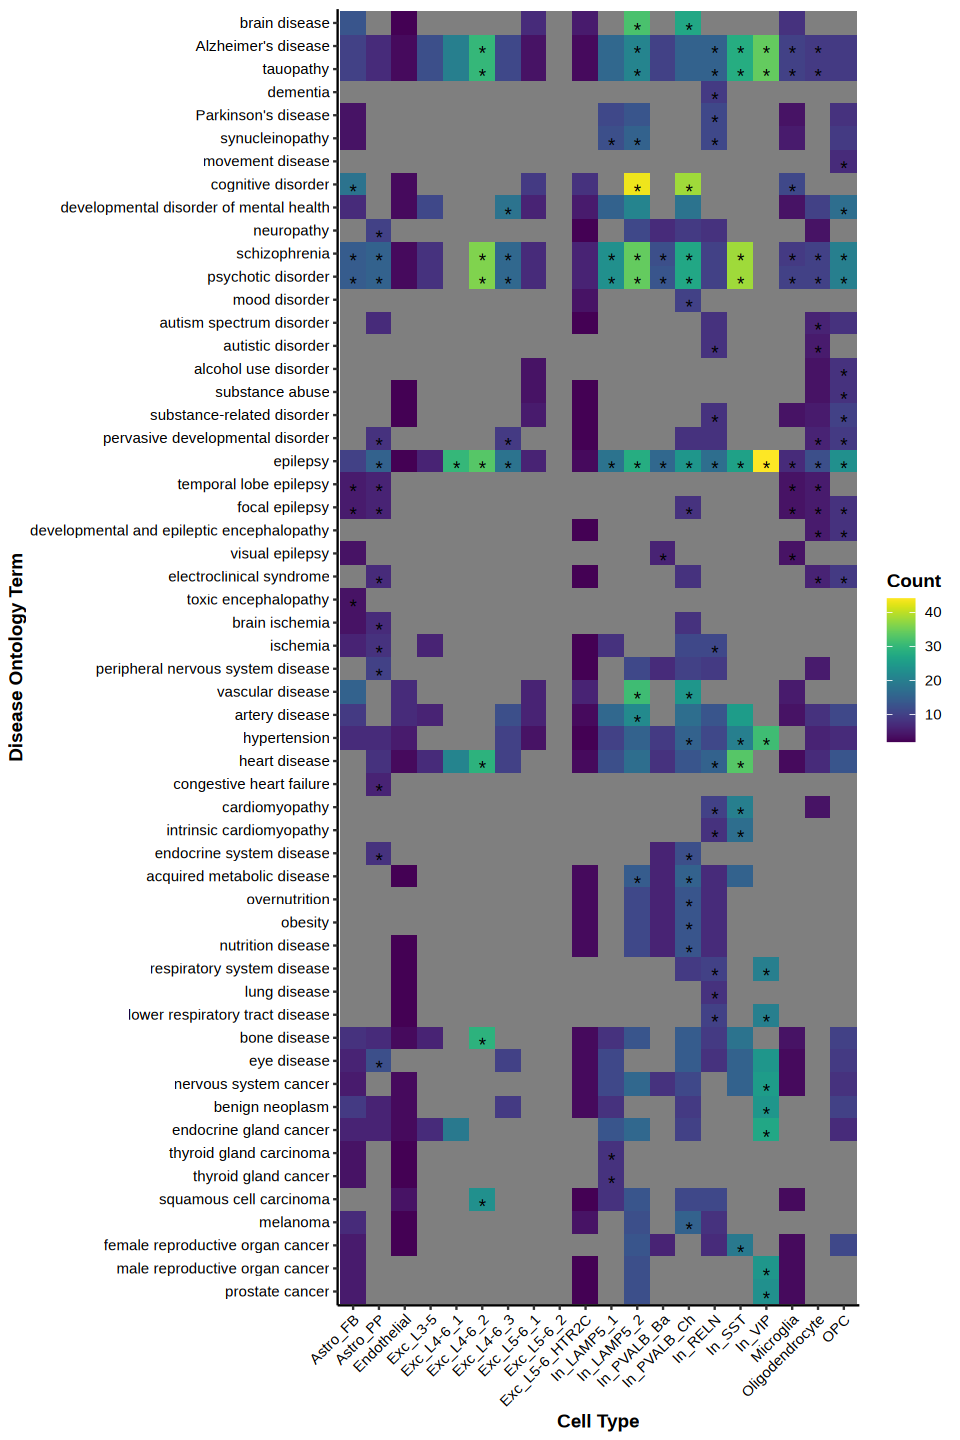

In [19]:
options(repr.plot.width=8, repr.plot.height=12)
ggplot(DO_final_down, aes(celltype, Description, fill= Count, label = ifelse(p.adjust < 0.05, "*", ""))) + 
  geom_tile() + theme_classic() + geom_text(vjust = 1, hjust = 0.5) +
  scale_fill_viridis(discrete=FALSE) +
  #scale_fill_gradient2("Count", low = "blue", mid = "white", high = "red", na.value = "grey70") +
  ylab("Disease Ontology Term") +
  xlab("Cell Type") + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, color="black"), 
                            axis.text.y = element_text(color='black'), axis.title = element_text(face='bold'), 
                            legend.title = element_text(face='bold'))

#ggsave('../figures/Disease_enrich_ORA_down_dreamlet.pdf', plot = last_plot(), height=12, width = 7.6)

In [20]:
DO_final_up$Description <- factor(DO_final_up$Description, levels= rev(c('demyelinating disease','multiple sclerosis',
                                                                     'mood disorder', 'bipolar disorder', 'substance-related disorder', 
                                                                     'substance abuse', 'arthritis', 'rheumatoid arthritis', 'artery disease',
                                                                     'hypertension', 'endocrine system disease', 'diabetes', 
                                                                     'glucose metabolism disease', 'obesity', 'overnutrition', 
                                                                     'Coronavirus infectious disease', 'parasitic infectious disease', 
                                                                     'parasitic helminthiasis infectious disease', 'hepatitis B',
                                                                     'integumentary system disease', 'skin disease', 
                                                                     'epidermolysis bullosa', 'vesiculobullous skin disease', 
                                                                     'bullous skin disease', 'dermatitis','vitiligo',
                                                                     'connective tissue disease', 'adenoma', 'cholangitis', 
                                                                     'hemorrhagic disease', 'auditory system disease', 
                                                                     'sensory system disease', 'glaucoma', 'open-angle glaucoma', 'low tension glaucoma',
                                                                     'extrinsic asthma', 'allergic asthma', 'chronic asthma', 
                                                                     'allergic disease', 'severe acute respiratory syndrome', 
                                                                     'lung disease', 'obstructive lung disease', 'chronic obstructive pulmonary disease',
                                                                     'gastrointestinal system disease', 'celiac disease', 'irritable bowel syndrome', 
                                                                     'liver cirrhosis', 'autoimmune disease','autoimmune disease of endocrine system', 'autoimmune disease of gastrointestinal tract',
                                                                     'bone disease', 'bone inflammation disease', 'myositis', 'muscle tissue disease', 
                                                                     'pancreatitis', 'pancreas disease', 'kidney disease', 'kidney failure', 
                                                                     'glomerulonephritis', 'nephritis', 'urinary system disease', 'benign neoplasm', 
                                                                     'cell type benign neoplasm', 'organ system benign neoplasm', 'nervous system cancer',
                                                                     'central nervous system cancer', 'reproductive system disease', 'female reproductive system disease', 'ovarian cancer', 
                                                                     'male reproductive organ cancer', 'prostate cancer', 'prostate carcinoma',
                                                                     'bone marrow cancer', 'esophageal cancer', 'endocrine gland cancer',
                                                                     'melanoma', 'myeloid neoplasm', 'respiratory system cancer', 'pancreatic cancer',
                                                                     'hepatobiliary system cancer')))

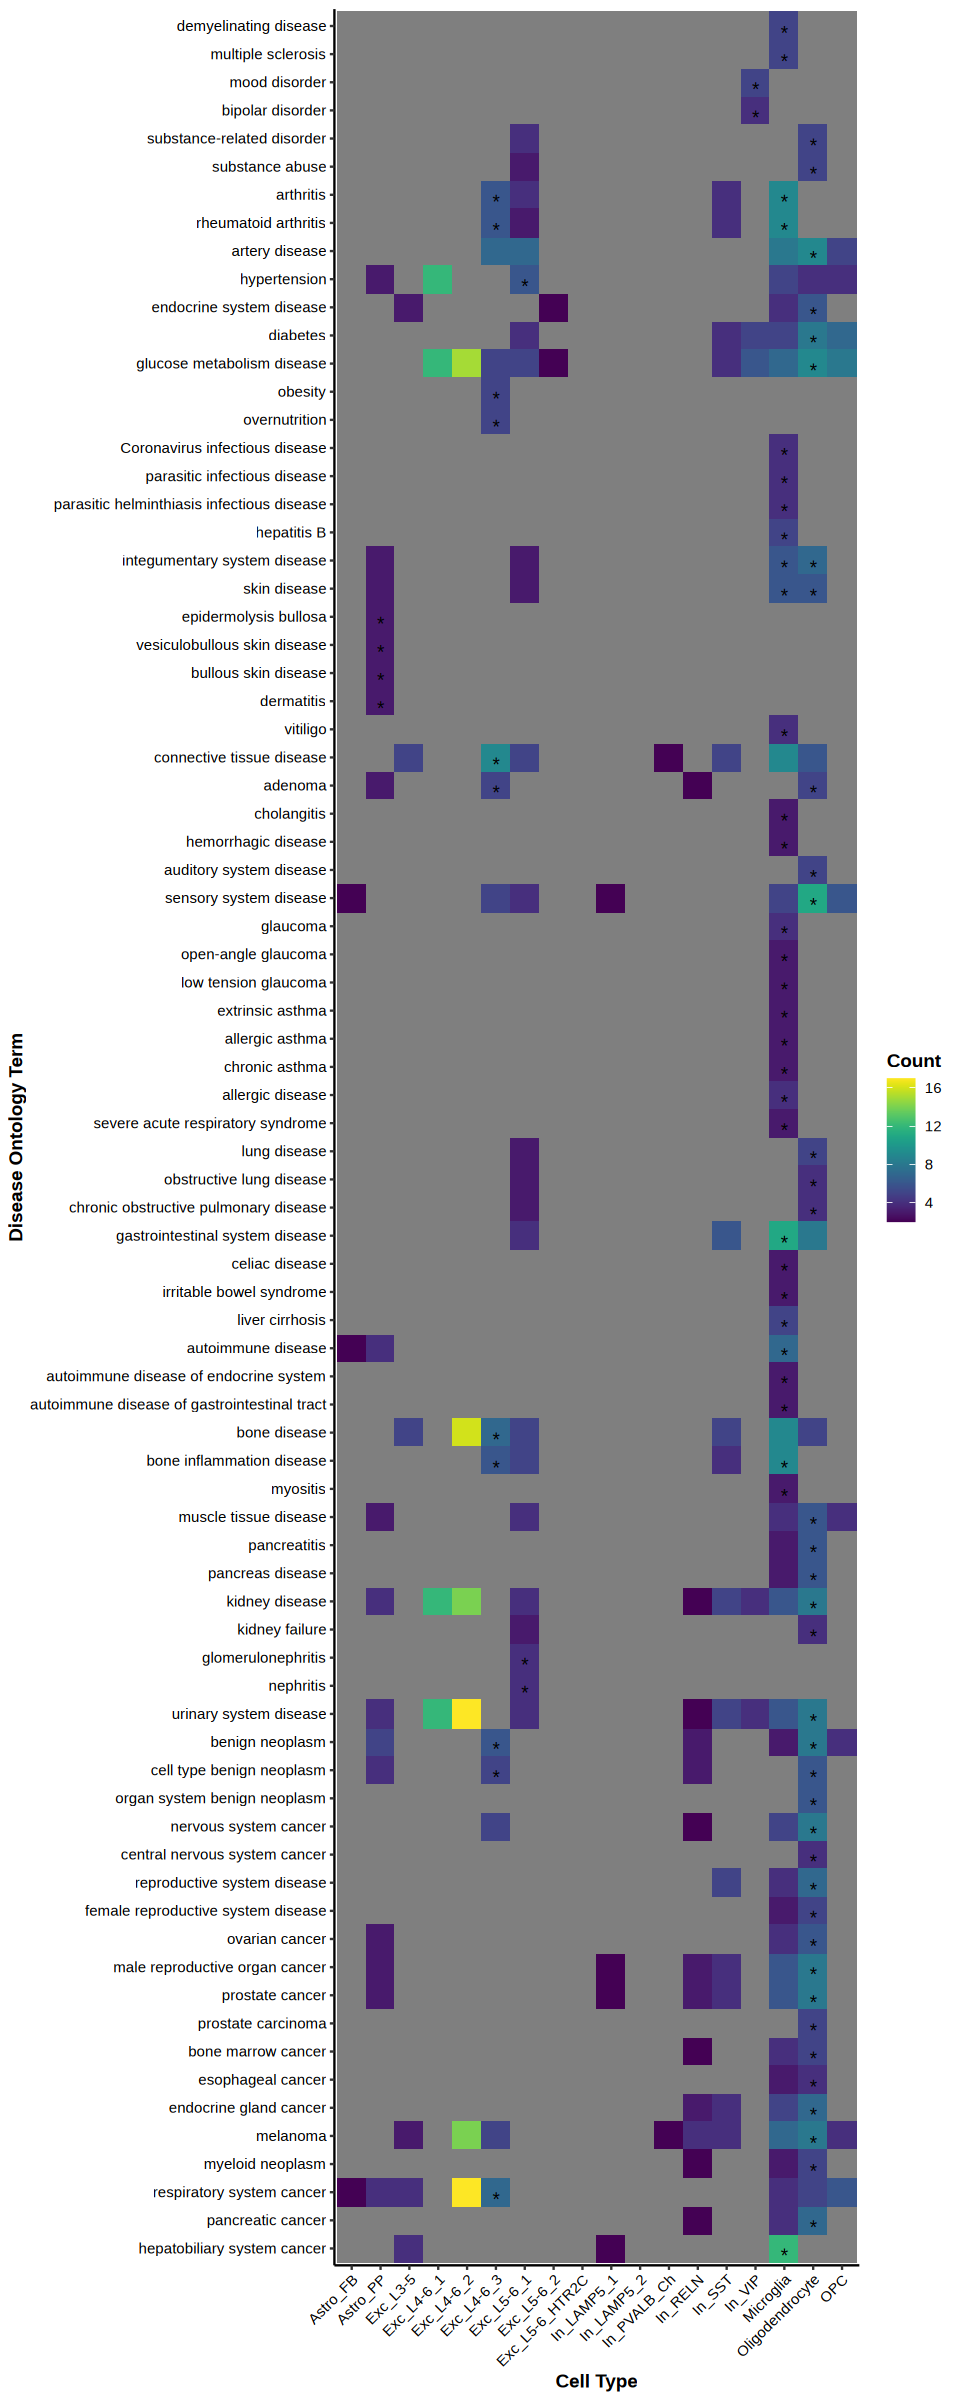

In [21]:
options(repr.plot.width=8, repr.plot.height=20)
ggplot(DO_final_up, aes(celltype, Description, fill= Count, label = ifelse(p.adjust < 0.05, "*", ""))) + 
  geom_tile() + theme_classic() + geom_text(vjust = 1, hjust = 0.5) +
  scale_fill_viridis(discrete=FALSE) +
  #scale_fill_gradient2("Count", low = "blue", mid = "white", high = "red", na.value = "grey70") +
  ylab("Disease Ontology Term") +
  xlab("Cell Type") + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, color="black"), axis.text.y = element_text(color='black'), axis.title = element_text(face='bold'), legend.title = element_text(face='bold'))

#ggsave('../figures/Disease_enrich_ORA_up_dreamlet.pdf', plot = last_plot(), height=16, width = 7)

# SessionInfo

In [22]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] DOSE_3.28.0            biomaRt_2.58.0         viridis_0.6.4         
 [4] viridisLite_0.4.2      cowplot_1.1.1          data.table_1.14.8     
 [7] org.Hs.eg.db_3.18.0    AnnotationD